<a href="https://colab.research.google.com/github/MarcoFogale/PetitesAnnoncesTraining/blob/main/02_Initial_Model_Evaluation_and_Deeper_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project by Marco Fogale**

# **A Machine Learning Approach to Vehicle Price Prediction in Peer-to-Peer Used Car Sales**

# 02 - Initial Model Evaluation and Deeper Exploratory Analysis

**Objectives**
- Initial Model Evaluation
  - Train and evaluate a LinearRegression model on the two more influencing features to establish a baseline
  - Analyse model behaviour and establish possible corrective actions
- Conduct an in-depth analysis of the unstructured text feature <i>description</i> and <i>model</i>
- Define the final feature space and Retrain Baseline
  - fine-tune the features selection
  - refine the data cleaning preprocessing steps accordingly with the in-depth analysis
  - retrain the baseline model on the final version of the dataset


#### **Mount Disk and Import Dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

# ------- preliminary EDA data cleaning --------
import sys
sys.path.append('/content/drive/MyDrive/_CapstoneProject_')
import preliminary_data_cleaning as pdc

# ------- Baseline evaluation dependecies --------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import  r2_score,  mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

# ---- text analysis libraries ----
import unicodedata
import spacy
import string

import nltk
nltk.download('omw-1.4')
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer

SEED = 73

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Load dataset

In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/_CapstoneProject_/petites_annonces_cars.csv', index_col=0)
df = pdc.preliminary_data_cleaning(raw_df)

## **Initial Model Evaluation**

Following the preliminary EDA, which revealed that year and mileage_km exhibit a strong relationship with the target variable, we opted against using the simple mean price as a baseline. Instead, we train a Linear Regression model based solely on these two features, in order to establish a baseline that is closer to the expected final performance and provides a more informative first assessment of the model's behavior, potential weaknesses, and areas for improvement.

### **Baseline Training**

> **Load dataset with reduced features space**

In [ ]:
df_baseline = df[['year', 'mileage_km', 'price']].copy()

In [ ]:
print(df_baseline.columns)
print(df_baseline.shape)

Index(['year', 'mileage_km', 'price'], dtype='object')
(3510, 3)


>**Prepare X matrices and y vectors for model training and evaluation**

In [ ]:
X = df_baseline.drop(columns=['price'])
y = df_baseline['price']

In [ ]:
X_train, X_test, y_train, y_test,  = train_test_split(X, y,  test_size=0.25, random_state=SEED)
print(len(X_train))
print(len(X_test))

2632
878


>**Train a LinearRegression model as baseline**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(), ['mileage_km', 'year'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['mileage_km', 'year'])])),
                ('regressor', LinearRegression())])

### **Baseline Evaluation**

>**Evaluate the baseline**

In [ ]:
y_pred = pipeline.predict(X_test)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(10**y_test, 10**y_pred))

R^2: 0.49037773392150663
MAE: 7134.347107720606


>**Write Results to File**

In [ ]:
model_name = 'Linear Regression Baseline'
lr_results_df = pd.DataFrame({
    'R^2': [r2_score(y_test, y_pred)],
    'MAE': [mean_absolute_error(10**y_test, 10**y_pred)],
}, index=[model_name])

**Observation**<br>
The obtained R^2 value of 0.49 indicates that approximately half of the variance in the dataset can be explained by the two selected features.

In addition, we evaluated the Mean Absolute Error (MAE) as a baseline metric due to its straightforward interpretability. The baseline model trained on the reduced feature space yeleded a MAE of 7134 CHF, which is considerably high give the objectives of the project.

**Decision**<br>
This first analysis highlight the necessity of constructing a more comprehensive feature space in order to improve the model performance and acheive prediction closer to the true market values.

### **Baseline Behaviour Inspection**

>**Plotting Baseline predictions versus true market prices**

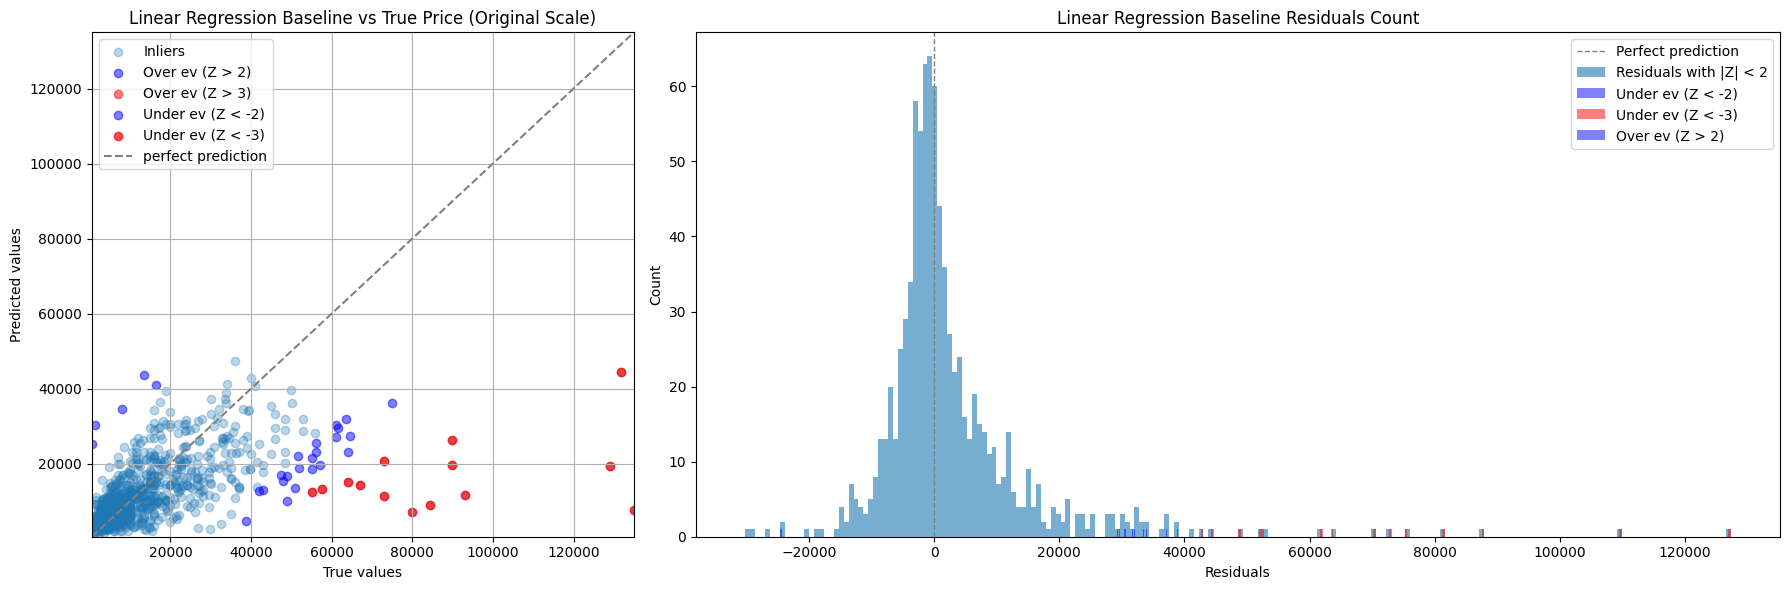

In [ ]:
model_kind = 'Linear Regression Baseline'
y_test_price = 10 ** y_test
y_pred_price = 10 ** y_pred

residuals = y_pred_price - y_test_price
residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)
z_scores = (residuals - residuals_mean) / residuals_std

price_overestimate_mask_2 = (z_scores > 2) & (z_scores < 3)
price_overestimate_mask_3 = z_scores > 3
price_underestimate_mask_2 = (z_scores < -2) & (z_scores > -3)
price_underestimate_mask_3 = z_scores < -3
inlier_mask = (~price_overestimate_mask_2) & (~price_underestimate_mask_2)

fig, ax = plt.subplots(1,2,figsize=(18, 6),  gridspec_kw={'width_ratios': [1, 2]},)
ax[0].scatter(y_test_price[inlier_mask], y_pred_price[inlier_mask],alpha=0.3,label='Inliers')
ax[0].scatter(y_test_price[price_overestimate_mask_2], y_pred_price[price_overestimate_mask_2], color='blue', alpha=0.5, label='Over ev (Z > 2)')
ax[0].scatter(y_test_price[price_overestimate_mask_3], y_pred_price[price_overestimate_mask_3], color='red', alpha=0.5, label='Over ev (Z > 3)')
ax[0].scatter(y_test_price[price_underestimate_mask_2], y_pred_price[price_underestimate_mask_2], color='blue', alpha=0.5, label='Under ev (Z < -2)')
ax[0].scatter(y_test_price[price_underestimate_mask_3], y_pred_price[price_underestimate_mask_3], color='red', alpha=0.7, label='Under ev (Z < -3)')

min_val = min(y_test_price.min(), y_pred_price.min())
max_val = max(y_test_price.max(), y_pred_price.max())
ax[0].set_xlim(min_val, max_val)
ax[0].set_ylim(min_val, max_val)
ax[0].plot([min_val, max_val], [min_val, max_val], '--', color='gray', label='perfect prediction')

ax[0].set_xlabel("True values")
ax[0].set_ylabel("Predicted values")
ax[0].set_title(f"{model_kind} vs True Price (Original Scale)")
ax[0].grid(True)
ax[0].legend()

residuals = -residuals

bins = 200

sns.histplot(residuals, ax=ax[1], bins=bins, stat="count", edgecolor=None, alpha=0.6, label="Residuals with |Z| < 2")

if (price_underestimate_mask_2.sum() > 1):
    sns.histplot(residuals[price_underestimate_mask_2], ax=ax[1],bins=bins, stat="count", color="blue", edgecolor=None, alpha=0.5, label="Under ev (Z < -2)")

if (price_underestimate_mask_3.sum() > 1):
    sns.histplot(residuals[price_underestimate_mask_3], ax=ax[1], bins=bins, stat="count", color="red", edgecolor=None, alpha=0.5, label="Under ev (Z < -3)")

if (price_overestimate_mask_2.sum() > 1):
    sns.histplot(residuals[price_overestimate_mask_2], ax=ax[1], bins=bins, stat="count", color="blue", edgecolor=None, alpha=0.5, label="Over ev (Z > 2)")

if (price_overestimate_mask_3.sum() > 1):
    sns.histplot(residuals[price_overestimate_mask_3], ax=ax[1], bins=bins, stat="count", color="red", edgecolor=None, alpha=0.5, label="Over ev (Z > 3)")

ax[1].axvline(0, linestyle='--', color='gray', linewidth=1, label='Perfect prediction')
ax[1].set_title(f"{model_kind} Residuals Count")
ax[1].set_xlabel("Residuals")
ax[1].set_ylabel("Count")
ax[1].legend()


plt.tight_layout()
plt.show()

**Observation**<br>
The scatter plot comparing baseline predictions with true values reveals that several predictions deviate substantially from the actual market prices.

The model exhibits a tendency to systematically underestimate high-priced vehicles (particularly luxury cars), whereas for vehicles priced up to 40,000 CHF, the prediction errors appear more balanced around the perfect prediction line.

In addition, a number of overestimated cases are visible, suggesting the presence of outliers that require further investigation.

>**Investigating underestimated luxury cars outliers**

In [ ]:
baseline_results = pd.DataFrame({
    'true_price': 10**y_test,
    'predicted_price': 10**y_pred,
    'residuals': 10**y_pred - 10**y_test,
    'z_scores': (10**y_pred - 10**y_test - np.mean(10**y_pred - 10**y_test)) / np.std(10**y_pred - 10**y_test)
})

In [ ]:
df_original = df[['brand','make', 'model_short','model_long', 'year', 'mileage_km', 'description']].copy()

In [ ]:
underestimated_outliers = df_original.join(baseline_results[price_underestimate_mask_3], how='inner')
underestimated_outliers.sort_values(by='z_scores', ascending=True)

,brand,make,model_short,model_long,year,mileage_km,description,true_price,predicted_price,residuals,z_scores
reference_number,,,,,,,,,,,
7021676,FERRARI,NICHE_MARKET_BRAND,F430,F430,2006,70000,Spider F1\nExpertisée (2021)\nCollecteur d'échappements refait à neuf\n,135000.0,7699.987266,-127300.012734,-9.613181
7446156,PORSCHE,PORSCHE,CABRIO,CABRIO 911.1 - 4 GTS PDK,2015,31100,Immaculate Carrera 4 GTS with the naturally aspirated 3.8 flat six. Swiss deliverery. Flawless service history. GT3 Wheels\nCondition parfaite. Historique des services impeccable. voiture suisse. Aspiration naturelle avec un son incroyable en mode sport. Roue et Jantes GT3\nKompletes Servicebuch. Perfekte Kondition. Schweizer Auto. Naturliche Sauger mit einem unglaublichen Motorenklang. Räder vom GT3\n,129000.0,19393.060219,-109606.939781,-8.247356
8055420,PORSCHE,PORSCHE,911,911 CARRERA,2024,16000,"Assistant de changement de voie\nBOSE® Surround Sound-System\nColonne de direction en cuir (en association avec le Pack mémoire)\nDirection assistée plus\nExtension de garantie 2 + 2 ans\nFeux arrière Exclusive Design\nFilet de rangement au pied du passager\nJupes latérales SportDesign\nParkAssistant avec Surround View\nPhares principaux à LED HD-Matrix assombris\nProjecteurs de porte à LED 911 Carrera T\nRäder lackiert in Schwarz (hochglanz)\nSportDesign carénage avant\nSuppression de l'inscription décorative latérale ""911 Carrera T""\n",131900.0,44326.819840,-87573.180160,-6.546451
7784424,FERRARI,NICHE_MARKET_BRAND,CALIFORNIA,CALIFORNIA,2009,31300,"Ferrari California 4.3, année 2009. services effectués agences officiel tous les trois milles kilomètre maximum. le dernier service fait à 31'000 km la voiture ne roule plus de puis (hivernage) annuel. Extérieur noir Daytona pinces de frein jaune, disque céramique carbone , écusson jaune sur les ailes avant plus élément carbone. Intérieur siège Daytona, tachymètre jaune, volant LED carbone plus options carbone.\nexpertisée du jour. Prix non négociable, personne non sérieuse s'abstenir. si l'annonce est en ligne c'est que le véhicule est toujours disponible.\n",93000.0,11635.035652,-81364.964348,-6.067205
7920185,LAMBORGHINI,NICHE_MARKET_BRAND,GALLARDO,GALLARDO LP560-4 COUPÉ E-G,2008,74950,"Véhicule en parfait état. Dernier Service effectué chez Lamborghini Porrentruy. Dernier contrôle embrayage à 3.9mm (rapport et factures à l'appui.) La voiture a été équipée avec un Autoradio récent aveccaméra de recul, antenne DAB+ et connectivité complète bluetooth/ USB.\n",84500.0,8944.744059,-75555.255941,-5.618722
6616704,LAMBORGHINI,NICHE_MARKET_BRAND,GALLARDO,GALLARDO E-GEA,2005,69000,"LAMBORGHINI Gallardo Coupé 5.0 E-Gear V10 500CV\nTrès bien entretenu, Intérieur et extérieur en très bon état\nExpertise (MFK) au 15.11.2021 et pratiquement pas roulé depuis.\nEmbrayage à 76% par Lamborghini check\nCompresseur de climatisation neuf 08.2024\n4'961 cm3\nCylindre: 10\npoids à vide : 1 595 kg\nprix d'origine: CHF 249'500.-\nÉquipement standard\n4 jantes alliage avec pneus\ntransmission à 6 vitesses\nAirbag : Airbag conducteur et passager avant\nTraction intégrale permanente\nSystème de freinage antiblocage (ABS)\nRétroviseurs extérieurs à droite et à gauche chauffants et réglables électriquement\naffichage de la température extérieure\nBoîte à gants éclairée et verrouillable\nPhares bi-xénon avec système de nettoyage\nordinateur de bord\nSystème de freinage Brembo\ntachymètre\nTroisième feu stop\nVitres électriques avant\nAmortissement du châssis à commande électronique avec contrôle de niveau\nProgramme de stabilité électronique (ESP)\nVitres teintées\nSpoiler arrière automatiquement\nContrôlé par catalyseur\nclimatisation automatique\nIntérieur cuir\nVolant réglable en longueur et en hauteur\nVolant et poignée de levier de vitesse en cuir\nRéglage automatique de la portée des phares\nEclairage : feu antibrouillard arrière\nRadio/cassette avec changeur de CD\nPréparation radio, antenne et suppression des interférences\nEssuie-

In [ ]:
df_porsche = df_original[df_original['brand'] == 'PORSCHE']
df_porsche_results = df_porsche.join(baseline_results, how='inner')
df_porsche_results.sort_values(by='z_scores', ascending=True)

,brand,make,model_short,model_long,year,mileage_km,description,true_price,predicted_price,residuals,z_scores
reference_number,,,,,,,,,,,
7446156,PORSCHE,PORSCHE,CABRIO,CABRIO 911.1 - 4 GTS PDK,2015,31100,Immaculate Carrera 4 GTS with the naturally aspirated 3.8 flat six. Swiss deliverery. Flawless service history. GT3 Wheels\nCondition parfaite. Historique des services impeccable. voiture suisse. Aspiration naturelle avec un son incroyable en mode sport. Roue et Jantes GT3\nKompletes Servicebuch. Perfekte Kondition. Schweizer Auto. Naturliche Sauger mit einem unglaublichen Motorenklang. Räder vom GT3\n,129000.0,19393.060219,-109606.939781,-8.247356
8055420,PORSCHE,PORSCHE,911,911 CARRERA,2024,16000,"Assistant de changement de voie\nBOSE® Surround Sound-System\nColonne de direction en cuir (en association avec le Pack mémoire)\nDirection assistée plus\nExtension de garantie 2 + 2 ans\nFeux arrière Exclusive Design\nFilet de rangement au pied du passager\nJupes latérales SportDesign\nParkAssistant avec Surround View\nPhares principaux à LED HD-Matrix assombris\nProjecteurs de porte à LED 911 Carrera T\nRäder lackiert in Schwarz (hochglanz)\nSportDesign carénage avant\nSuppression de l'inscription décorative latérale ""911 Carrera T""\n",131900.0,44326.819840,-87573.180160,-6.546451
6449853,PORSCHE,PORSCHE,CAYENNE,CAYENNE S 420 TIPTRONIC A,2014,105700,"Porsche Cayenne S 420ch Tiptronic A crossover, suv, marron, 31 cv, 5 portes, première mise en circulation le 04/09/2014,\n5 places\nOPTIONS ET EQUIPEMENTS :\nExtérieur :\n- allumage automatique des feux\n- rétroviseurs électriques\n- rétroviseurs rabattables\n- toit ouvrant\n- toit ouvrant électrique\n- vitres électriques\n- phares xenon\n- jantes aluminium\nIntérieur et confort :\n- accoudoir central\n- auto-radio commandé au volant\n- banquette 1/3 - 2/3\n- ordinateur de bord\n- sièges chauffants\n- sièges électriques\n- volant multifonctions\n- volant réglable\n- bluetooth\n- sièges réglables en hauteur\n- aide au démarrage en pente\n- volant cuir\n- radio CD\n- climatisation automatique\n- GPS\nSécurité :\n- détecteur de pluie\n- direction assistée\n- fermeture centralisée\n- ABS\n- airbags frontaux\n- airbags latéraux\n- alarme\n- anti-démarrage\n- anti-patinage\n- contrôle pression des pneus\n- ESP\n- phares antibrouillard\n- radar avant de détection d'obstacles\n- radar arrière de détection d'obstacles\n- fixation ISOFIX\n- airbags rideaux\n- régulateur de vitesse\n- limiteur de vitesse\nAutres équipements et informations :\n- kilométrage garanti\n- puissance réelle : 420 ch\n- émission CO2 : 2garanti\n- radar d'aide au stationnement\n- Puissance kilowatt : 309 kw\n- auto-radio\n- jantes aluminium\n- Aide au freinage d'urgence\n- Verrouillage automatiques des porte\ns en roulant\n- Intérieur cuir\n- Stop & start\n- Vitre surteintées\nSur rdv à Paris svp\n",57700.0,13141.710572,-44558.289428,-3.225898
4809748,PORSCHE,PORSCHE,MACAN,MACAN,2017,30000,Porche Macan tdi\n,64000.0,23090.605822,-40909.394178,-2.944220
7360053,PORSCHE,PORSCHE,MACAN,MACAN GTS PDK,2018,68000,"Equipement standard\nAccoudoir central AR\nAirbag: Airbag conducteur et passager\nAirbag: Airbag passager désactivable\nAirbag: Airbags latéraux\nAirbag: Curtain Airbag\nAirbag: Thorax Airbags latéraux pour conducteur et passager\nAppui-têtes actifs\nAssist: Fonction Auto-Hold\nAssist: Hill Desent Control\nAssist: Porsche Traction Management (PTM)\nAssistance de freinage\nAuto Installation démarrage/stop\nBaguettes décoratives de\nBaguettes latérales décoratives de\nBas de caisse\nBoîte à 7 vitesses séquentielle\nBoîte à gants refroidie\nBoîte à gants éclairée et verrouillable\nCache moyeu de roue avec blason couleur\nCatalyseur réglé\nCeintures AV réglables en hauteur\nCeintures de sécurité à 3 points à toutes les places\nClima: Climatisation automatique confort 3 zones\nConsole centrale avec vide-poches\nContrôle de ceinture\nCouverture de compartiment de charge\nCouvertures pour les seuils avec Logo\nDétecteur d

**Observation**<br>
Among the most erroneous prediction figure some well known luxury cars brand, which had already been identified as "niche brands". These brands, similarly to vintage cars, occupy a special market segment and their presence in the dataset is limited to a few entries, which make impossible to correctly train a model for this population.

Other samples belongs to brands that are more representated, like Porsche. This highlight how the presence of the model feature is important, as different models belonging to the same brand can have a completely different market behaviour. In this case, even though Porsche is a well known luxury cars productor, some models like Cayenne or Macan align their prices better with the ratio "year" and "mileage" than other models, that we can consider supercars, like the 911 Carrera.

This short analysis also highligh the presence of important information, like "cabrio" or "turbo" that could better explain the variance, and that, if not removed first from the model feature, could even lead to errors in model identification (see first "cabrio" sample from the Porsche results dataset).


**Decision**<br>
Two correction will be applied:
- adding a step to the preprocessing cleaning function removing FERRARI, LAMBORGHINI, BENTLEY brands.
- analysing in deep the model long feature along with the "description" text feature

In [ ]:
# 1 - removing luxury supercars brands
df = df[~df['brand'].isin(['FERRARI', 'LAMBORGHINI', 'BENTLEY'])]
df.shape

(3503, 20)

> **Investigating overestimated samples**

In [ ]:
overestimated_outliers = df_original.join(baseline_results[price_overestimate_mask_2], how='inner')
overestimated_outliers.sort_values(by='z_scores', ascending=False)

,brand,make,model_short,model_long,year,mileage_km,description,true_price,predicted_price,residuals,z_scores
reference_number,,,,,,,,,,,
7937078,HYUNDAI,HYUNDAI,BAYON,BAYON ORIGO,2024,20000,"Hyundai Bayon Origo de janvier 2024 totalise 20 000 km et a bénéficié d'un entretien complet. Son passage sous la grêle lui donne un look unique, mais n'altère en rien ses performances. Elle est également couverte par 5 ans de garantie granite.\nPris Neuf : 26'000 CHF\nSes points forts :\nSécurité & aides à la conduite :\n* ABS, ESP, répartiteur électronique de freinage (EBD)\n* Airbags avant, latéraux et rideaux\n* Assistance freinage d'urgence, appel d'urgence\n* Aide au démarrage en côte\n* Aide au maintien de voie (LKA) et Lane Tracing Assist\n* Détecteur de fatigue\n* Régulateur et limiteur de vitesse\n* Caméra de recul intégrée au rétroviseur intérieur\nTechnologie & connectivité :\n* Apple CarPlay & Android Auto\n* Système de navigation MapCare avec mise à jour des cartes\n* Reconnaissance des panneaux de signalisation\n* Commande audio au volant\n* Chargeur sans fil (Wireless Charging)\n* Connexion USB & Bluetooth\nConfort & design :\n* Climatisation manuelle\n* Éclairage d'ambiance\n* Volant et levier de vitesse en cuir, réglable\n* Accoudoir central avant\n* Lève-vitres électriques avant et arrière\n* Rétroviseurs électriques, chauffants et rabattables\n* Sièges arrière rabattables 60/40, siège conducteur réglable en hauteur\n* Vitres arrière teintées (Privacy-Verglasung)\nÉclairage & visibilité :\n* Phares avant Full LED, feux arrière LED\n* Feux de jour LED\n* Phares directionnels statiques\n* Capteur de lumière\nAutres équipements pratiques :\n* Système Start & Stop\n* Surveillance de pression des pneus (RDK)\n* Préparation attelage & fixation siège enfant Isofix\n* Kit de réparation de pneus\n",13400.0,43609.878368,30209.878368,2.545862
5035111,FORD,FORD,MUSTANG,MUSTANG,2019,5000,"Ford Mustang Shelby GTE 670 CV à vendre.\nmodèle UNIQUE en Suisse, grise anthracite, capot carbone, full option.\nIntérieur avec logo Shelby sur les sièges et logo Shelby. incrusté à l'intérieur du capot\nIl s'agit d'une reprise de leasing (très facile pour personne solvable) chez Bank Now, avec un acompte de 5'000 CHF, le leasing est d'une durée totale de 60 mois avec la première échéance qui a débuté en avril 2019, la valeur résiduelle du véhicule est de 53'000 CHF, avec un km limité à 15'000 par an.\nJe remets mon petit bijoux, à mon grand regret, suite à une perte emploi.\njantes de 20 pouces et jeu de jantes de 19 pouces.\n",1166.0,30306.617094,29140.617094,2.463320
7949286,DACIA,NICHE_MARKET_BRAND,SPRING,SPRING,2022,35000,"A vendre une belle petite citadine Dacia Spring en très bon état!\nLe service est à jour (chez Dacia), les pneus neufs, roule très bien et la batterie tient bien, comme neuve!\nGarantie ( d'usine) de la batterie jusqu'au 2029!\nPour toute question complémentaire n'hésitez pas à me contacter...\n",7900.0,34608.835693,26708.835693,2.275598
5697367,MERCEDES-BENZ,MERCEDES-BENZ,C43,C43 AMG,2019,51000,"Prix à discuter\nReprises leasing\nAcompte Frs.14000.- et 24 X 554.95/ mois ou 59000.-\nGarantie d'usine jusqu'à 02.2023\nService gratuit 10 ans ou 120 000 km\nAnnée 2019\nKm 51000\n390 ch et 520Nm\n4x4\nBoîte automatique séquentielle 9 rapports\nVoiture non fumeur\nToit ouvrant panoramique\nSystème sonore Burmester\nSiège AMG performance chauffants, électriques et mémoire\nEchappement AMG a clapets\nCamera 360\nPark pilote avant et arrière\nJantes d'origine 19 pouces\nJantes été japan racing 20 pouces\nRabaissée avec ressort court\nTraitement céramique\nFeux arrière teinté\nDifférentes pièces en covering noir\nVitres arrière teintées sombres\nBande par soleil\nOuverture du coffre électrique y compris avec le pied\nPhares à led matrix automatiques\nAssistant de changement de voie actif\nConduite semi-autonome\nToujours bien entretenu chez Mercedes\nLe service vient d'être fait\nY compris ressorts d'origine\nPour plus d'informations 

**Observation**<br>
Two samples clearly represent erroneous entries that the first preliminary EDA couldn't detect. The Ford Mustang and the Mercedez C43 report the leasing monthly price instead of the sale price.

Dacia is also a "niche" brand, but it's clearly in a completely different market segment of other brands.

**Decision**<br>
Two actions need to be taken:
- improving the preprocessing data cleaning function to exclude also listings including the word "leasing" and a price less than 2000 CHF
- approach the niche brand grouping differently, creating differents groups based on their appartenance to different market segments highlighted during the preliminary EDA. This approach, initially discarted, appear now a better solution, the underlying assomption being that every car make specialise on a determined market segment, which needs to be re-evaluated overtime (an example of an important switch in market segment is the brand <i>Chevrolet</i>, which historically produced supercars and now commercialise entry-level city-cars).

In [ ]:
# 2 - removing sample presenting keyword LEASING and price less than 2000 CHF
df =  df[~((df.description.str.upper().str.contains('LEASING')) & (10**(df.price) < 2000))]
df.shape

(3500, 20)

In [ ]:
# 3 - redifine niche brands
niche_brands_dict = {
  'ASTON MARTIN'  : 'NICHE_LUXURY_BRAND',
  'LOTUS'         : 'NICHE_LUXURY_BRAND',
  'TESLA'         : 'NICHE_LUXURY_BRAND',
  'JAGUAR'        : 'NICHE_LUXURY_BRAND',
  'MASERATI'      : 'NICHE_LUXURY_BRAND',
  'ROVER'         : 'NICHE_LUXURY_BRAND',

  'DODGE'         : 'NICHE_PREMIUM_BRAND',
  'LOTUS'         : 'NICHE_PREMIUM_BRAND',
  'LEXUS'         : 'NICHE_PREMIUM_BRAND',
  'CADILLAC'      : 'NICHE_PREMIUM_BRAND',
  'RELIANT'       : 'NICHE_PREMIUM_BRAND',
  'INFINITI'      : 'NICHE_PREMIUM_BRAND',
  'PONTIAC'       : 'NICHE_PREMIUM_BRAND',

  'AUTRES'        : 'NICHE_MASS_MARKET_BRAND',
  'NO_BRAND'      : 'NICHE_MASS_MARKET_BRAND',
  'DACIA'         : 'NICHE_MASS_MARKET_BRAND',
  'KIA'           : 'NICHE_MASS_MARKET_BRAND',
  'MITSUBISHI'    : 'NICHE_MASS_MARKET_BRAND',
  'SUZUKI'        : 'NICHE_MASS_MARKET_BRAND',
  'SSANG YONG'    : 'NICHE_MASS_MARKET_BRAND',
  'SAAB'          : 'NICHE_MASS_MARKET_BRAND',
  'CHEVROLET'     : 'NICHE_MASS_MARKET_BRAND',
  'MG'            : 'NICHE_MASS_MARKET_BRAND',
  'LANCIA'        : 'NICHE_MASS_MARKET_BRAND',
  'SMART'         : 'NICHE_MASS_MARKET_BRAND',

  'CHRYSLER'      : 'NICHE_ECONOMY_BRAND',
  'DAIHATSU'      : 'NICHE_ECONOMY_BRAND',
  'DAEWOO'        : 'NICHE_ECONOMY_BRAND'
}

# modify the make column taking the specification into account
df['make'] = df['brand'].map(niche_brands_dict).fillna(df['make'])

> **Define a plot residual function to use for all models, to compare performace**

In [ ]:
%%writefile  /content/drive/MyDrive/_CapstoneProject_/plot_residuals.py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def plot_residuals(y_test, y_pred, model_kind):
  y_test_price = 10 ** y_test
  y_pred_price = 10 ** y_pred

  residuals = y_pred_price - y_test_price
  residuals_mean = np.mean(residuals)
  residuals_std = np.std(residuals)
  z_scores = (residuals - residuals_mean) / residuals_std

  price_overestimate_mask_2 = (z_scores > 2) & (z_scores < 3)
  price_overestimate_mask_3 = z_scores > 3
  price_underestimate_mask_2 = (z_scores < -2) & (z_scores > -3)
  price_underestimate_mask_3 = z_scores < -3
  inlier_mask = (~price_overestimate_mask_2) & (~price_underestimate_mask_2)

  fig, ax = plt.subplots(1,2,figsize=(18, 6),  gridspec_kw={'width_ratios': [1, 2]},)
  ax[0].scatter(y_test_price[inlier_mask], y_pred_price[inlier_mask],alpha=0.3,label='Inliers')
  ax[0].scatter(y_test_price[price_overestimate_mask_2], y_pred_price[price_overestimate_mask_2], color='blue', alpha=0.5, label='Over ev (Z > 2)')
  ax[0].scatter(y_test_price[price_overestimate_mask_3], y_pred_price[price_overestimate_mask_3], color='red', alpha=0.5, label='Over ev (Z > 3)')
  ax[0].scatter(y_test_price[price_underestimate_mask_2], y_pred_price[price_underestimate_mask_2], color='blue', alpha=0.5, label='Under ev (Z < -2)')
  ax[0].scatter(y_test_price[price_underestimate_mask_3], y_pred_price[price_underestimate_mask_3], color='red', alpha=0.7, label='Under ev (Z < -3)')

  min_val = min(y_test_price.min(), y_pred_price.min())
  max_val = max(y_test_price.max(), y_pred_price.max())
  ax[0].set_xlim(min_val, max_val)
  ax[0].set_ylim(min_val, max_val)
  ax[0].plot([min_val, max_val], [min_val, max_val], '--', color='gray', label='perfect prediction')

  ax[0].set_xlabel("True values")
  ax[0].set_ylabel("Predicted values")
  ax[0].set_title(f"{model_kind} vs True Price (Original Scale)")
  ax[0].grid(True)
  ax[0].legend()

  residuals = -residuals

  bins = 200

  sns.histplot(residuals, ax=ax[1], bins=bins, stat="count", edgecolor=None, alpha=0.6, label="Residuals with |Z| < 2")

  if (price_underestimate_mask_2.sum() > 1):
      sns.histplot(residuals[price_underestimate_mask_2], ax=ax[1],bins=bins, stat="count", color="blue", edgecolor=None, alpha=0.5, label="Under ev (Z < -2)")

  if (price_underestimate_mask_3.sum() > 1):
      sns.histplot(residuals[price_underestimate_mask_3], ax=ax[1], bins=bins, stat="count", color="red", edgecolor=None, alpha=0.5, label="Under ev (Z < -3)")

  if (price_overestimate_mask_2.sum() > 1):
      sns.histplot(residuals[price_overestimate_mask_2], ax=ax[1], bins=bins, stat="count", color="blue", edgecolor=None, alpha=0.5, label="Over ev (Z > 2)")

  if (price_overestimate_mask_3.sum() > 1):
      sns.histplot(residuals[price_overestimate_mask_3], ax=ax[1], bins=bins, stat="count", color="red", edgecolor=None, alpha=0.5, label="Over ev (Z > 3)")

  ax[1].axvline(0, linestyle='--', color='gray', linewidth=1, label='Perfect prediction')
  ax[1].set_title(f"{model_kind} Residuals Count")
  ax[1].set_xlabel("Residuals")
  ax[1].set_ylabel("Count")
  ax[1].legend()


  plt.tight_layout()
  plt.show()

Overwriting /content/drive/MyDrive/_CapstoneProject_/plot_residuals.py


> **Retrain and evaluate Linear Regression Baseline on improved dataset**

In [ ]:
df_baseline_improved = df[['year', 'mileage_km', 'price']].copy()

X = df_baseline_improved.drop(columns=['price'])
y = df_baseline_improved['price']

X_train, X_test, y_train, y_test,  = train_test_split(X, y,  test_size=0.25, random_state=SEED)
print(len(X_train))
print(len(X_test))

preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(), ['mileage_km', 'year'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(10**y_test, 10**y_pred))

model_name = 'Linear Regression Baseline (improved dataset)'
lr_2_results_df = pd.DataFrame({
    'R^2': [r2_score(y_test, y_pred)],
    'MAE': [mean_absolute_error(10**y_test, 10**y_pred)],
}, index=[model_name])

2625
875
R^2: 0.49353544349755785
MAE: 6864.154390365411


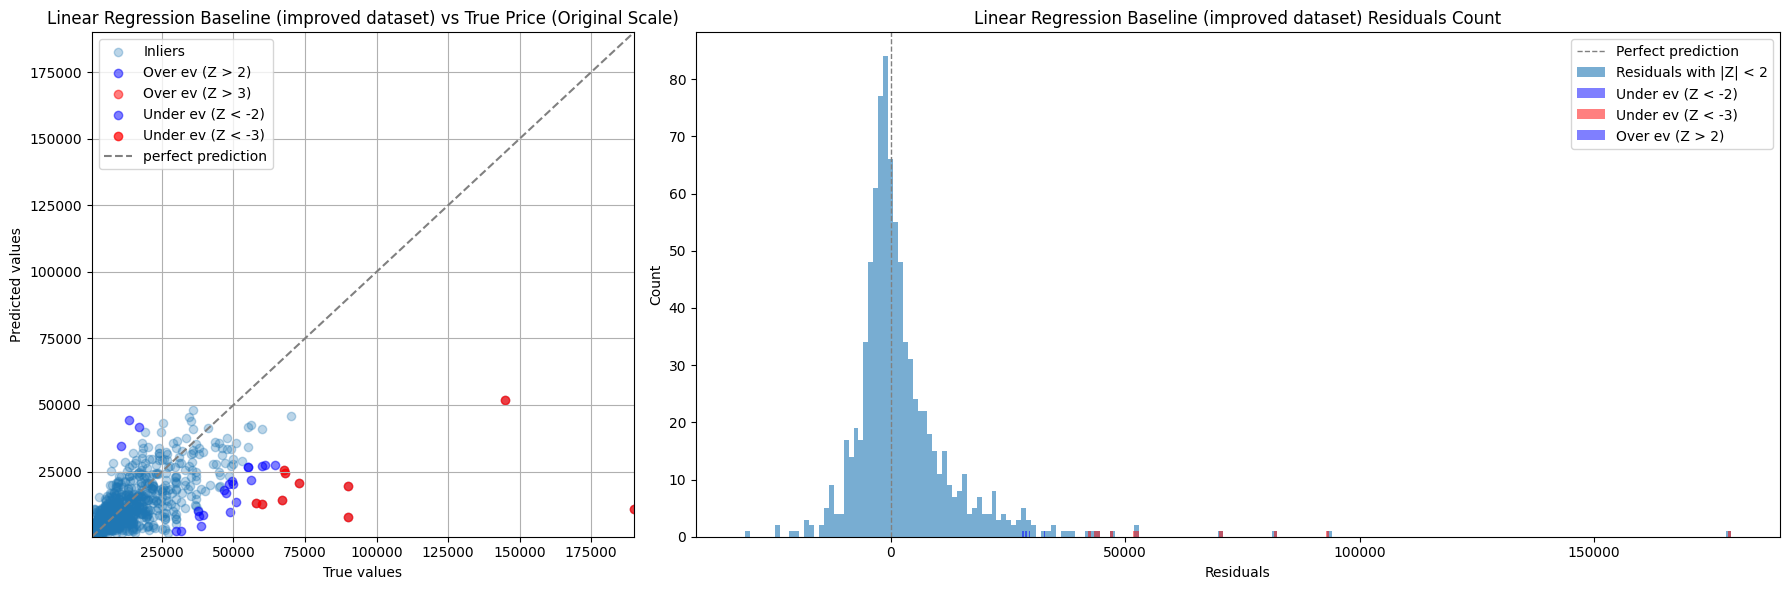

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/_CapstoneProject_')
import plot_residuals as plt_res

plt_res.plot_residuals(y_test, y_pred, model_name)

>**Observation**

After the further investigation, performance of the reduced dataset baseline slightly improves, but some abnormal values are still present, and the performance is not yet satisfactory, as a mean difference from the true value of almost 7000 Swiss Francs is too important, and we can't state that this simple baseline model generalize sufficiently well on this dataset.


### **Linear Regression Baseline on entire preliminary eda cleaned dataset**

In [ ]:
preliminary_eda_selected_columns = [
    'price',
    'year',
    'mileage_km',
    'transmission',
    'fuel',
    'external_color_grouped',
    'external_color_shade',
    'external_color_metallic',
    'internal_color_grouped',
    'internal_color_shade',
    'internal_color_leather'
]
df_baseline_preliminary_eda = df[preliminary_eda_selected_columns].copy()
df_baseline_preliminary_eda.shape

(3500, 11)

In [ ]:
X = df_baseline_preliminary_eda.drop(columns=['price'])
y = df_baseline_preliminary_eda['price']
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test,  = train_test_split(X, y,  test_size=0.25, random_state=SEED)
print(len(X_train))
print(len(X_test))


preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(),['year', 'mileage_km']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), [
      'transmission',
      'fuel',
      'external_color_grouped',
      'external_color_shade',
      'external_color_metallic',
      'internal_color_grouped',
      'internal_color_shade',
      'internal_color_leather'
    ])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(10**y_test, 10**y_pred))

model_name = 'Linear Regression Baseline (preliminary EDA dataset)'
lr_3_results_df = pd.DataFrame({
    'R^2': [r2_score(y_test, y_pred)],
    'MAE': [mean_absolute_error(10**y_test, 10**y_pred)],
}, index=[model_name])

(3500, 10)
(3500,)
2625
875
R^2: 0.6263646972637003
MAE: 5659.000894666455


> **Conclusion**

The Linear Regression baseline model trained on the cleanest dataset obtained from the previous preliminary EDA generalizes better, but the performance is still unsatisfactory for the purpouse of the model.

During the preliminary EDA we holded on the description feature, as it contains a lot of unstructured pieces of information. The text is used to specify further details of a listing, and extracting and restructuring the contained pieces of information could have result in features probably mostly populated by missing values.

> **Decision**

As the performance of the Linear Regression Baseline result still too far from a reasonable approximation of a car price, we decide before investigating the performance of other, more complex models, to improve the features space information adding an in-depth analysis of the text features.

## **In-Depth Analysis of the Unstructured Text Features**

### Description Feature

#### **Preprocessing and standardizing operations**

> **Converting to lowercase**

In [ ]:
# 1 - convert to lowercase
df['description'] = df.description.str.lower()

> **Normalize Accents**

In [ ]:
# 2 - normalize accents
def strip_accents(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

df['description'] = df['description'].apply(strip_accents)

> **Tokenization**

In [ ]:
# 3 - tokenization
tokenizer = TreebankWordTokenizer()
def review_tokinzer(text):
  words = []
  words.extend(tokenizer.tokenize(text))
  return words

df['description'] = df.description.apply(lambda x: review_tokinzer(x))

> **Stopwords Removal**

In [ ]:
# 4 - stopwords removal
stopwords_french = stopwords.words("french")
not_stopwords = ['pas', 'sans', 'n', 'ne', 'ni']
custom_stopwords = set(
    [word for word in stopwords_french if word not in not_stopwords]
)
print("{} stopwords in customized NLTK's list.\n".format(len(custom_stopwords)))

df.description = df.description.apply(
    lambda x: [word for word in x if word not in custom_stopwords]
)

154 stopwords in customized NLTK's list.



> **Ponctuation Removal**

In [ ]:
# 5 - ponctuation removal
df['description'] = df.description.apply(lambda x: [word for word in x if word not in string.punctuation])

> **Stemming**

In [ ]:
# 6 - stemming
stemmer = PorterStemmer()
df['description'] = df.description.apply(lambda x: [stemmer.stem(word) for word in x])
df['description'] = df.description.apply(lambda x: " ".join(x))

In [ ]:
df.description.sample(5)

,description
reference_number,
8072849,"magnifiqu cabriolet z4 super vehicul 6 cylindr 2,5 tre bien entretenu toujour stationn garage. jamai roul l'hiver. peu kilometr car j'ai plusieur vehicules. a essay voir a ballaigu"
7942782,etat neuf 2 litr turbo diesel 150 cv doubl roue frigo cuisin couchett gp command volant ect expertise garanti encor vw pret a partir l'aventur
4606649,a vent
6954084,a vendr citroen e-c4 swiss edit voitur electriqu 43 000km garanti voitur 5 an 100 000 km garanti batteri 8 an 4 roue alu ete 4 roue alu hiver prochain servic a 50 000 km
7841749,vend opel corsa 1.4l edit 90 aut. pack confort volant cuir chauffant tempomat pack hiver 4 roue hiver 4 roue ete aid stationn avant arrier port usb 25500km prix 14999.- a discut ok premier mise circul 17.01.2019 dernier expertis 17.07.2024 a disposit tout question +41 79 781 79 00 whatsapp ok dernier mise a jour 18.01.2024


####**Basic EDA of Description feature**

>**Words counts and distribution**



In [ ]:
# 1 - create descripton length feature
df['description_length'] = df.description.apply(lambda x: len(x.split()))

count    3500.000000
mean       43.367429
std        53.131278
min         1.000000
25%        16.000000
50%        27.000000
75%        49.250000
max       464.000000
Name: description_length, dtype: float64


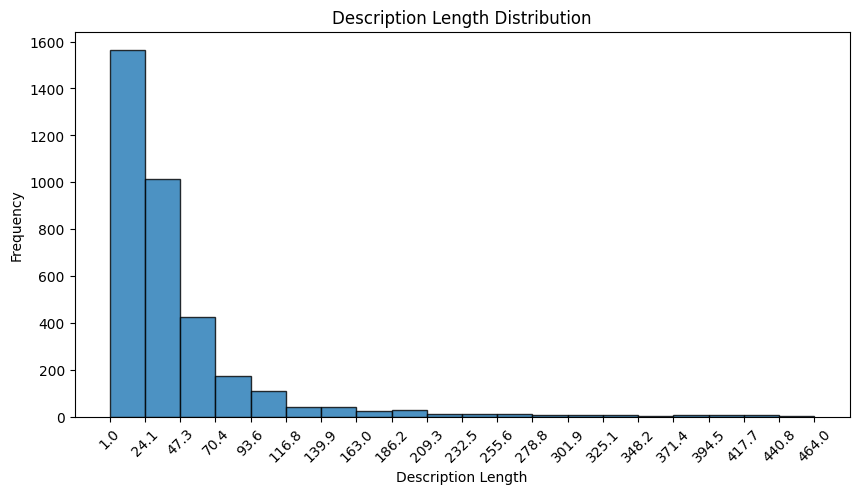

In [ ]:
print(df['description_length'].describe())

fig, ax = plt.subplots(figsize=(10,5))
counts, bins, patches = plt.hist(df['description_length'], bins=20, alpha=0.8, edgecolor='black')
plt.xticks(bins, rotation=45)
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.title('Description Length Distribution')
plt.show()

> **Investigating the relationship between decription length and the target variable**

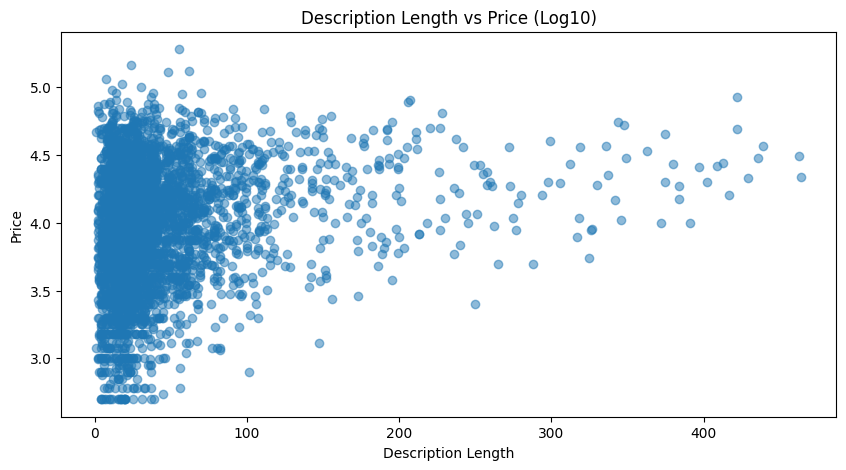

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df['description_length'], df['price'], alpha=0.5)
ax.set_xlabel('Description Length')
ax.set_ylabel('Price')
ax.set_title('Description Length vs Price (Log10)')
plt.show()

In [ ]:
df['description_length'].corr(df['price'])

np.float64(0.213254664058632)

**Observation**<br>
Following text preprocessing, most listings are characterized by very short descriptions, typically not exceeding 24 words.

A positive association can be observed between description length and vehicle price: longer descriptions (exceeding 150 words) often correspond to higher-priced vehicles, likely reflecting the inclusion of numerous options and features.

**Decision**<br>
The description length will be included in the final features space selection

> **Unigrams and Bigrams Analysis**

We proceed with the analysis of the description field with the aim of extracting the maximum amount of relevant information, while limiting an excessive expansion of the feature space.

Several strategies can be applied to reduce the dimensionality of the sparse matrix produced by text vectorization and to obtain a denser, more informative representation. These include unsupervised dimensionality reduction techniques such as TruncatedSVD.

In this study, however, we adopt a vocabulary reduction strategy, based on the identification of domain-specific keywords and their potential synonyms. Although this approach requires a considerable degree of manual effort, it provides a deeper understanding of the raw dataset and results in a feature space that is straightforward to interpret.

> **Extract Unigrams (single words) and Bigrams in a sparse one-hot encoded matrix**

In [ ]:
# 1 - extract unigrams "flags"
count_unigrams_vec = CountVectorizer(
    ngram_range=(1,1),
    min_df=5,
    binary = True
)
descriptions_unigrams_count = count_unigrams_vec.fit_transform(df.description)

unigram_counts = descriptions_unigrams_count.sum(axis=0).A1
unigrams = count_unigrams_vec.get_feature_names_out()

# 2 - extract bigrams "flags"
count_bigram_vec = CountVectorizer(
    ngram_range=(2,2),
    min_df=5,
    binary = True
)
descriptions_bigrams_count = count_bigram_vec.fit_transform(df.description)

bigrams_counts = descriptions_bigrams_count.sum(axis=0).A1
bigrams = count_bigram_vec.get_feature_names_out()

In [ ]:
# 3 - transform the two sparses matrices into datasets
df_unigrams = pd.DataFrame(
    descriptions_unigrams_count.toarray(),
    index=df.index,
    columns=unigrams
)

df_bigrams = pd.DataFrame(
    descriptions_bigrams_count.toarray(),
    index=df.index,
    columns=bigrams
)

print(df_unigrams.shape)
print(df_bigrams.shape)

(3500, 2666)
(3500, 3901)


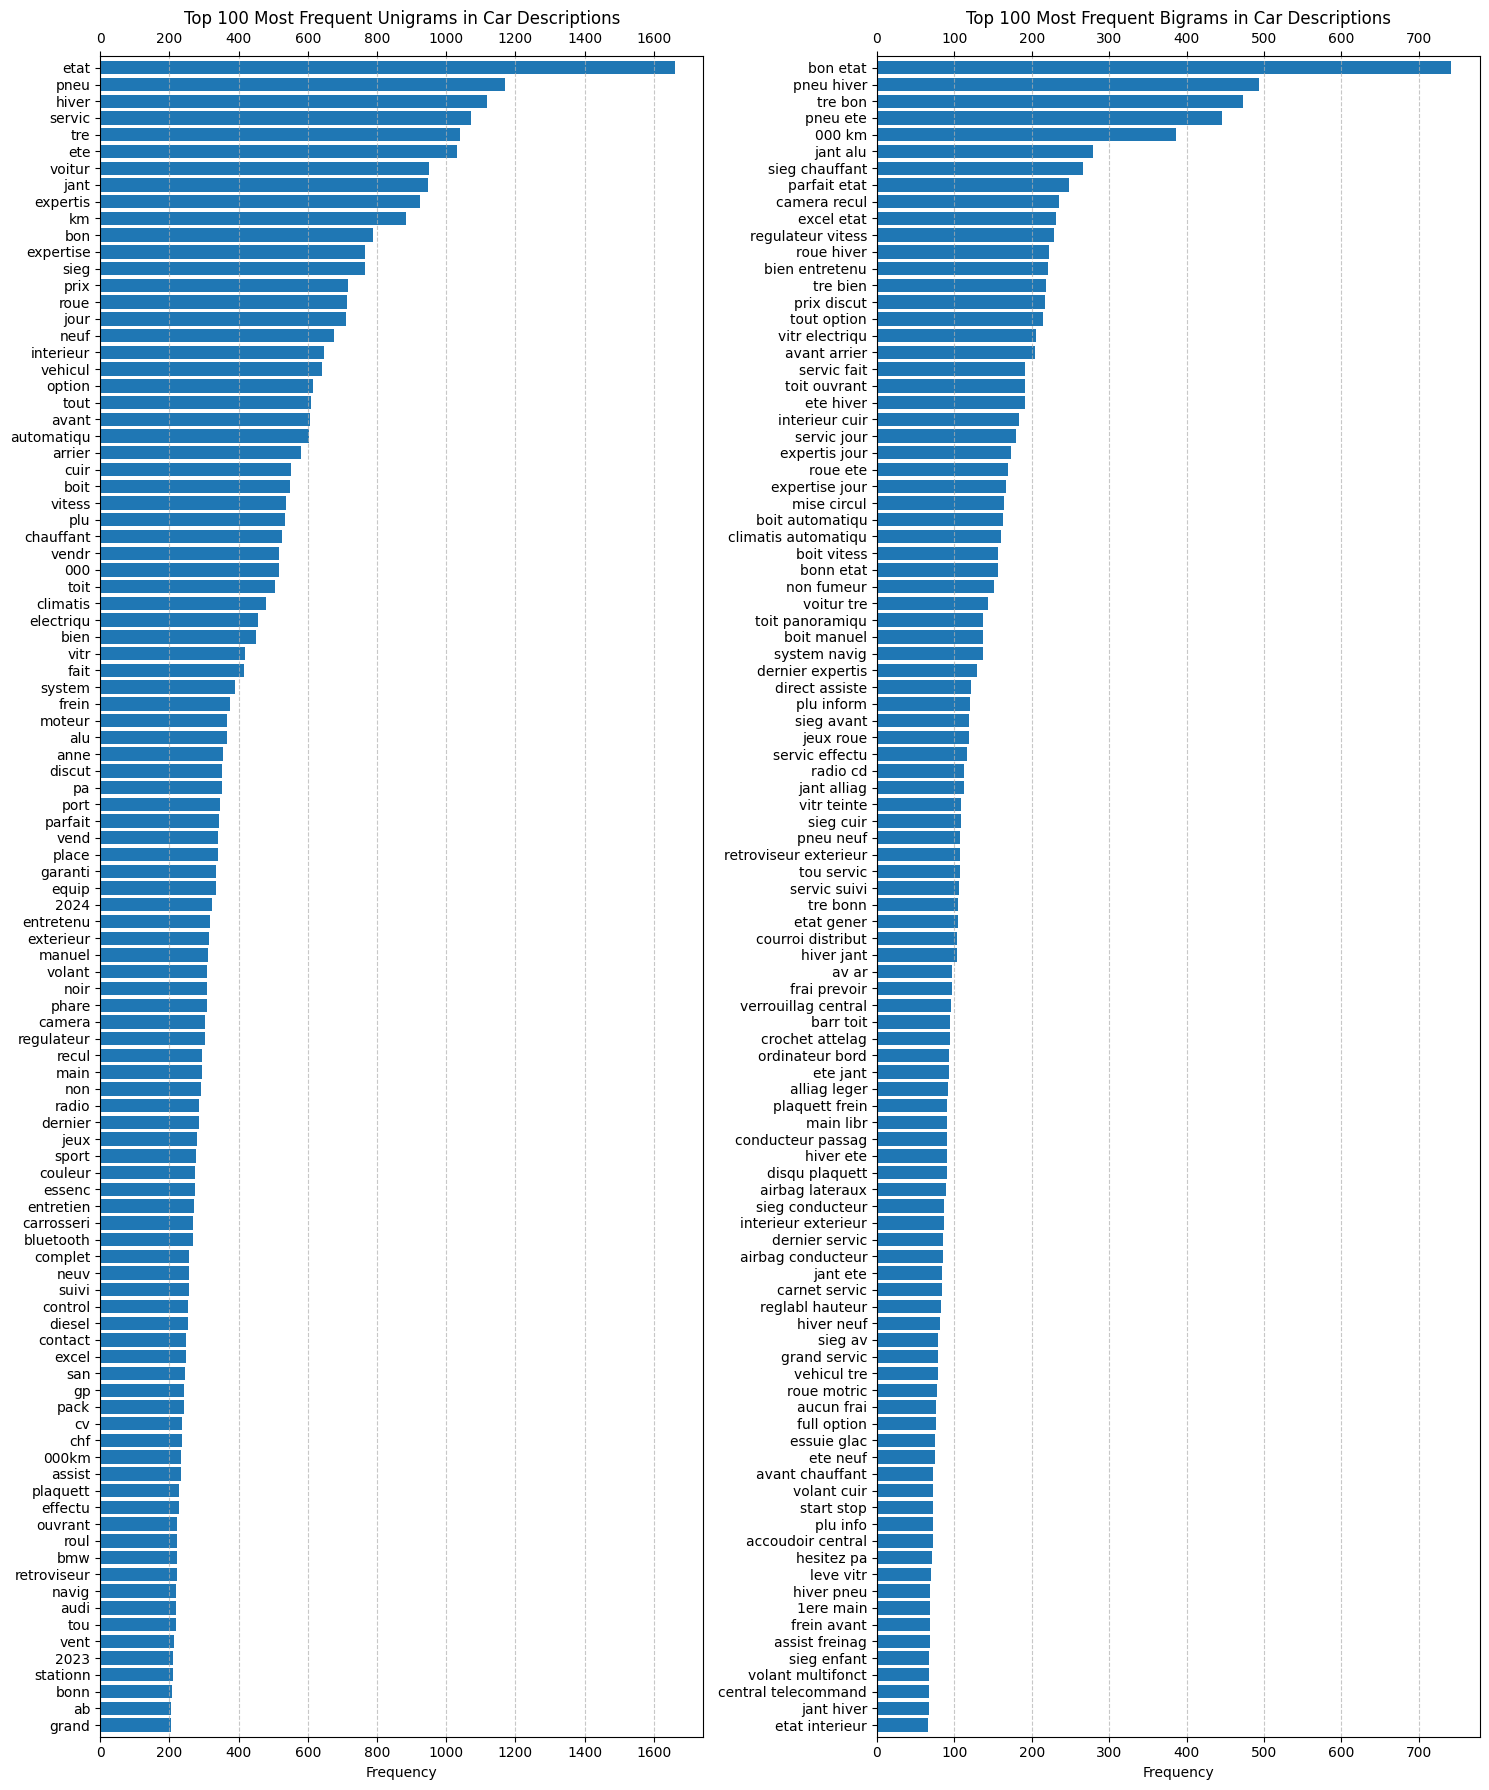

In [ ]:
top_n_grams = 100
unigram_freq = pd.DataFrame({"word": unigrams, "count": unigram_counts})
unigram_freq = unigram_freq.sort_values("count", ascending=False).head(top_n_grams).sort_values("count", ascending=True)

bigram_freq = pd.DataFrame({"word": bigrams, "count": bigrams_counts})
bigram_freq_top_n = bigram_freq.sort_values("count", ascending=False).head(top_n_grams).sort_values("count", ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 18))

ax[0].barh(unigram_freq["word"], unigram_freq["count"])
ax[0].set_xlabel("Frequency")
ax[0].tick_params(axis='x', top=True, labeltop=True)
ax[0].set_title(f"Top {100} Most Frequent Unigrams in Car Descriptions")
ax[0].grid(axis='x', linestyle='--', alpha=0.7)
ax[0].tick_params(axis='x', top=True, labeltop=True)
margin = 0.2
ax[0].set_ylim(-0.5 - margin, len(unigram_freq["word"]) - 0.5 + margin)

ax[1].barh(bigram_freq_top_n["word"], bigram_freq_top_n["count"])
ax[1].set_xlabel("Frequency")
ax[1].tick_params(axis='x', top=True, labeltop=True)
ax[1].set_title(f"Top {100} Most Frequent Bigrams in Car Descriptions")
ax[1].grid(axis='x', linestyle='--', alpha=0.7)
margin = 0.2
ax[1].set_ylim(-0.5 - margin, len(bigram_freq_top_n["word"]) - 0.5 + margin)

plt.tight_layout()
plt.show()

**Observation**<br>
Apart from a few keywords clearly representing some options which presence can be "flagged" and that could have a clear correlation with the market price, the unigram analysis is not explanatory because the same keyword could imply an opposite meaning depending of the context.

As an example the key word <i>expertise</i> (technical mandatory inspection):
- "expertisée du jour": inspection recently executed, vehicle is guarantee to be in good conditions and won't require any maintenance in the next one or two years.
- "à expertiser": exacly the opposite meaning.

The keyword that appear the most concern the car's condition. This is another example of key word that completely change meaning, depending on the context.

**Decision**<br>
- Extract the vehicles conditions from a selection of keywords taken as unigrams or bigrams.

- Extract other vehicle's technical characteristics from a selection of keywords among the 100 most frequent unigrams and bigrams, and create a synonym dictionary for the bigrams that could be expressed in several diffent ways but that imply the same semantic meaning.


In [ ]:
# 4 - join unigrams and bigrams
df_description_features = df_unigrams.join(
    df_bigrams,
    how='inner'
)

> **Vehicle Conditions Score**
We define four categories of vehicle's conditions:
- Very bad condition: heavily damaged vehicles, sold without warranty and mainly of interest for export.
- Minor wear: vehicles with some defects requiring repair, but still in usable state.
- Good condition: typical second-hand cars that have received regular maintenance.
- Excellent condition: vehicles highlighted by the seller as being in superior state, potentially justifying a higher price.

In [ ]:
# 1 - create a very_bad_condition flag
uni_bi_grams = [
    'abim',
    'abime',
    'export',
    'impact',
    'san garanti',
    'san garantie',
    'aucun garanti'
]

existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

if existing_cols:
    df_description_features['very_bad_condition'] = df_description_features[existing_cols].max(axis=1)
else:
    df_description_features['very_bad_condition'] = 0

percentage_bad_condition = df_description_features[df_description_features['very_bad_condition'] ==1].shape[0] / df_description_features.shape[0]
print(f'Percentage of cars with bad conditioins: {(percentage_bad_condition)*100} %')

Percentage of cars with bad conditioins: 3.085714285714286 %


In [ ]:
# 2 - create a minor_wear_condition flag
uni_bi_grams = [
   'defaut'
  ,'defectueux'
  ,'griff'
  ,'griffur'
  ,'marqu'
  ,'trace'
  ,'rayur'
  ,'bruit'
  ,'usur'
  ,'rouill'
  ,'petit travaux'
  ,'travaux prevoir'
]

existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

if existing_cols:
    df_description_features['minor_wear_condition'] = df_description_features[existing_cols].max(axis=1)
else:
    df_description_features['minor_wear_condition'] = 0

percentage_minr_wear_condition = df_description_features[df_description_features['minor_wear_condition'] ==1].shape[0] / df_description_features.shape[0]
print(f'Percentage of cars with minor wear conditions: {(percentage_minr_wear_condition)*100} %')

Percentage of cars with minor wear conditions: 7.8 %


In [ ]:
# 3 - create a good_condition flag
uni_bi_grams = [
    'jamai accident'
  , 'jamai accidente'
  , 'non accident'
  , 'non accidente'
  , 'non accidentee'
  , 'quasi neuf'
  , 'quasi neufs'
  , 'quasiment neuf'
  , 'travaux effectu'
  , 'aucun problem'
  , 'aucun souci'
  , 'aucun defaut'
  , 'pa problem'
  , 'san problem'
  , 'san souci'
  , 'bon'
  , 'bonn'
  , 'affair'
  , 'correct'
  , 'entretenu'
  , 'entretenue'
  , 'confortable'
  , 'fiabilit'
  , 'fiabilite'
  , 'fiabl'
  , 'fiable'
  , 'fonctionnel'
  , 'fraichement'
  , 'normal'
  , 'soign'
  , 'soigne'
  , 'soignee'
  , 'soigner'
  , 'soigneus'
  , 'soin'
  , 'reguli'
  , 'regulier'
  , 'regulierement'
]

existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

if existing_cols:
    df_description_features['good_condition'] = df_description_features[existing_cols].max(axis=1)
else:
    df_description_features['good_condition'] = 0

percentage_good_condition = df_description_features[df_description_features['good_condition'] ==1].shape[0] / df_description_features.shape[0]
print(f'Percentage of cars with good conditions: {(percentage_good_condition)*100} %')

Percentage of cars with good conditions: 43.05714285714286 %


In [ ]:
# 3 - create a excellent_condition flag
uni_bi_grams = [
      'bijou'
    , 'excel'
    , 'excellent'
    , 'except'
    , 'exceptionnel'
    , 'exclusif'
    , 'exclusiv'
    , 'super'
    , 'superb'
    , 'elegant'
    , 'impec'
    , 'impecc'
    , 'impeccable'
    , 'intemporel'
    , 'irreproch'
    , 'irreprochable'
    , 'magnifiqu'
    , 'meilleur'
    , 'neuf'
    , 'neufs'
    , 'neuv'
    , 'neuve'
    , 'neuves'
    , 'nouveau'
    , 'nouveaux'
    , 'nouvel'
    , 'parfait'
    , 'parfaitement'
    , 'rigoureux'
    , 'special'
    , 'speciaux'
]

existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

if existing_cols:
    df_description_features['excellent_condition'] = df_description_features[existing_cols].max(axis=1)
else:
    df_description_features['excellent_condition'] = 0

percentage_excellent_condition = df_description_features[df_description_features['excellent_condition'] ==1].shape[0] / df_description_features.shape[0]
print(f'Percentage of cars with excellent conditions: {(percentage_excellent_condition)*100} %')

Percentage of cars with excellent conditions: 45.6 %


>**Technical Characteristics**

In [ ]:
# 1 -  unigram features selection
tec_char_unigrams_to_retain = ['economiqu', 'airbag', 'xenon', 'led', 'crochet']
for f in tec_char_unigrams_to_retain:
    if f not in df_unigrams.columns:
        df_unigrams[f] = 0

df_unigrams = df_unigrams[tec_char_unigrams_to_retain]

In [ ]:
# 2 - create groups of synonyms
expenses_features_to_group = ['aucun frai', 'pa frai']
winter_tire_features_to_group = ['pneu hiver', 'pneu neig', 'roue hiver', 'roue neig', 'jant hiver', 'jant neig']
summer_tire_features_to_group = ['pneu ete',  'roue ete',  'jant ete']
tires_ok_features_to_group = ['pneu bon', 'pneu neuf', 'jeux pneu', 'jeu pneu', 'pneu quasi', 'roue bon', 'roue bonn', 'roue neuv', 'roue quasi', 'jeu roue']
full_option_to_group = ['tout option', 'full option', 'nombreus option', 'beaucoup option']
rearview_camera_to_group = ['camera recul', 'rearview camera']
recent_inspection_to_group = ['expertise jour', 'expertis jour']
recent_service_to_group = ['service jour', 'service fait', 'servic effectue', 'servic suivi', 'tou servic', 'carnet servic', 'grand servic', 'carnet entretien']
non_smoking_to_group = ['non fumeur', 'non fumeus']
first_hand_to_group = ['premier main', '1ere main']
sound_system_to_group = ['haut parleur', 'system audio']
sunroof_to_group = ['toit ouvrant', 'toit panoramiqu']

In [ ]:
# 3 - select only existing ones
expenses_features_existing = [f for f in expenses_features_to_group if f in df_bigrams.columns]
winter_tire_features_existing = [f for f in winter_tire_features_to_group if f in df_bigrams.columns]
summer_tire_features_existing = [f for f in summer_tire_features_to_group if f in df_bigrams.columns]
tires_ok_features_existing = [f for f in tires_ok_features_to_group if f in df_bigrams.columns]
full_option_existing = [f for f in full_option_to_group if f in df_bigrams.columns]
rearview_camera_existing = [f for f in rearview_camera_to_group if f in df_bigrams.columns]
recent_inspection_existing = [f for f in recent_inspection_to_group if f in df_bigrams.columns]
recent_service_existing = [f for f in recent_service_to_group if f in df_bigrams.columns]
non_smoking_existing = [f for f in non_smoking_to_group if f in df_bigrams.columns]
first_hand_existing = [f for f in first_hand_to_group if f in df_bigrams.columns]
sound_system_existing = [f for f in sound_system_to_group if f in df_bigrams.columns]
sunroof_existing = [f for f in sunroof_to_group if f in df_bigrams.columns]

In [ ]:
# 4 - group per semanting meaning in a single one-hot encoded feature
df_bigrams["expenses"] =  df_bigrams[expenses_features_existing].any(axis=1).astype(int) if len(expenses_features_existing) > 0 else 0
df_bigrams["winter_tire"] =  df_bigrams[winter_tire_features_existing].any(axis=1).astype(int) if len(winter_tire_features_existing) > 0 else 0
df_bigrams["summer_tire"] =  df_bigrams[summer_tire_features_existing].any(axis=1).astype(int) if len(summer_tire_features_existing) > 0 else 0
df_bigrams["tires_ok"] =  df_bigrams[tires_ok_features_existing].any(axis=1).astype(int) if len(tires_ok_features_existing) > 0 else 0
df_bigrams["full_option"] =  df_bigrams[full_option_existing].any(axis=1).astype(int) if len(full_option_existing) > 0 else 0
df_bigrams["rearview_camera"] =  df_bigrams[rearview_camera_existing].any(axis=1).astype(int) if len(rearview_camera_existing) > 0 else 0
df_bigrams["recent_inspection"] =  df_bigrams[recent_inspection_existing].any(axis=1).astype(int) if len(recent_inspection_existing) > 0 else 0
df_bigrams["recent_service"] =  df_bigrams[recent_service_existing].any(axis=1).astype(int) if len(recent_service_existing) > 0 else 0
df_bigrams["non_smoking"] =  df_bigrams[non_smoking_existing].any(axis=1).astype(int) if len(non_smoking_existing) > 0 else 0
df_bigrams["first_hand"] =  df_bigrams[first_hand_existing].any(axis=1).astype(int) if len(first_hand_existing) > 0 else 0
df_bigrams["sound_system"] =  df_bigrams[sound_system_existing].any(axis=1).astype(int) if len(sound_system_existing) > 0 else 0
df_bigrams["sunroof"] =  df_bigrams[sunroof_existing].any(axis=1).astype(int) if len(sunroof_existing) > 0 else 0

In [ ]:
# 5 - determine a list of bigrams with no synonym (no grouping required)
bigrams_with_no_synonims = [
    'sieg chauffant',
    'regulateur vitess',
    'prix discut',
    'vitr electriqu',
    'climatis automatiqu',
    'system navig',
    'direct assiste',
    'courroi distribut',
    'verrouillag central',
    'barr toit',
    'disqu plaquett',
    'main libr',
    'airbag lateraux',
    'roue motric',
    'accoudoir central',
    'detecteur pluie',
    'phare antibrouillard',
    'volant multifonct',
    'volant cuir',
    'assist freinag',
    'start stop'
]

for f in bigrams_with_no_synonims:
    if f not in df_bigrams.columns:
        df_bigrams[f] = 0

In [ ]:
# 6 - keep only selected bigrams and standardize features names
tec_char_bigrams_to_retain = ['expenses', 'winter_tire', 'summer_tire', 'tires_ok', 'full_option', 'rearview_camera', 'recent_inspection', 'recent_service', 'non_smoking', 'first_hand', 'sound_system', 'sunroof'] + bigrams_with_no_synonims
df_bigrams = df_bigrams[tec_char_bigrams_to_retain]
df_bigrams.columns = df_bigrams.columns.str.replace(" ", "_")

>**Check for Features Coverage and Correlation and make a final selection of Description Features**

In [ ]:
# 7 - join with conditions features
conditions_features = ['very_bad_condition', 'minor_wear_condition', 'good_condition', 'excellent_condition']
df_description_features = df_description_features[conditions_features].join(df_unigrams.join(df_bigrams),how='inner')

In [ ]:
df_description_features['price'] = df['price']

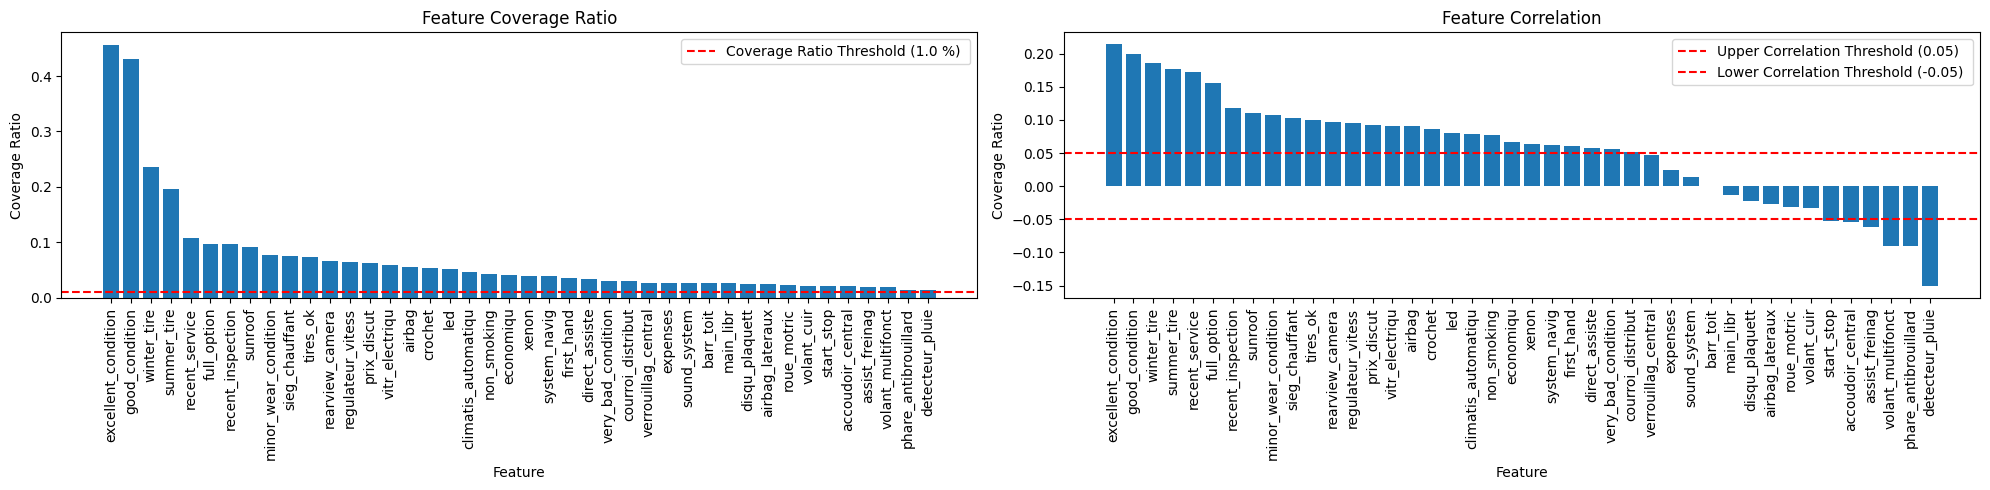

In [ ]:
count_values = pd.DataFrame({"coverage_ratio":df_description_features.drop(columns=['price']).sum() / df_description_features.shape[0], "correlation":df_description_features.drop(columns=['price']).corrwith(df_description_features["price"])})

coverage_treshold = 0.01
fig, ax = plt.subplots(1,2,figsize=(20, 5))
count_values_sorted_cov = count_values.sort_values("coverage_ratio", ascending=False)
ax[0].bar(count_values_sorted_cov.index, count_values_sorted_cov["coverage_ratio"])
ax[0].axhline(y=coverage_treshold, color='r', linestyle='--', label=f'Coverage Ratio Threshold ({coverage_treshold * 100} %) ')
ax[0].set_xlabel("Feature")
ax[0].set_ylabel("Coverage Ratio")
ax[0].set_title("Feature Coverage Ratio")
ax[0].set_ylabel("Coverage Ratio")
ax[0].tick_params(axis='x', rotation=90)
ax[0].legend()

correlation_treshold = 0.05
count_values_sorted_corr = count_values.sort_values("correlation", ascending=False)
ax[1].bar(count_values_sorted_cov.index, count_values_sorted_corr["correlation"])
ax[1].axhline(y=correlation_treshold, color='r', linestyle='--', label=f'Upper Correlation Threshold ({correlation_treshold}) ')
ax[1].axhline(y=-1*correlation_treshold, color='r', linestyle='--', label=f'Lower Correlation Threshold ({-1 * correlation_treshold}) ')
ax[1].set_xlabel("Feature")
ax[1].set_ylabel("Coverage Ratio")
ax[1].set_title("Feature Correlation")
ax[1].set_ylabel("Coverage Ratio")
ax[1].tick_params(axis='x', rotation=90)
ax[1].legend()

plt.tight_layout()
plt.show()

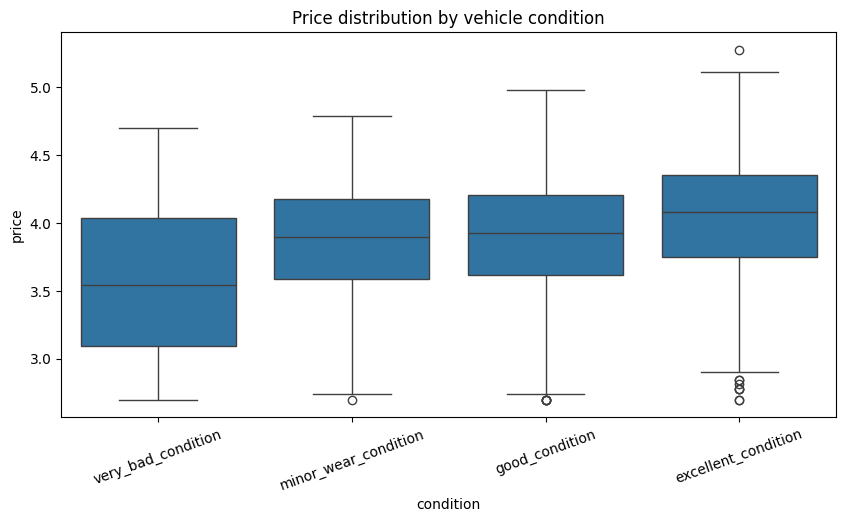

In [ ]:
df_cond = df_description_features.melt(id_vars='price', value_vars=conditions_features,var_name='condition', value_name='flag')
df_long = df_cond[df_cond['flag'] == 1]

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_long, x='condition', y='price')
plt.xticks(rotation=20)
plt.title('Price distribution by vehicle condition')
plt.show()


**Conclusion**<br>
Some of the newly created features present an extremely low correlation and will be discarted from the final model.

It's interesting to notice that the very_bad_condition feature hold a weak positive correlation with the price, despite the fact that vehicles presenting these characteristics obtain a lower average price on the market. This could happen because they represent only a small fraction of the dataset and their statistical signal may be dominated by a few expensive outliers.

In [ ]:
# 8 ---- finalise description features selection
description_features_to_retain = [
  'very_bad_condition',
  'minor_wear_condition',
  'good_condition',
  'excellent_condition',
  'economiqu',
  'airbag',
  'xenon',
  'led',
  'crochet',
  'expenses',
  'winter_tire',
  'summer_tire',
  'tires_ok',
  'full_option',
  'rearview_camera',
  'recent_inspection',
  'recent_service',
  'non_smoking',
  'first_hand',
  'sound_system',
  'sunroof',
  'sieg_chauffant',
  'regulateur_vitess',
  'prix_discut',
  'vitr_electriqu',
  'climatis_automatiqu',
  'system_navig',
  'direct_assiste',
  'courroi_distribut',
  'verrouillag_central',
  'detecteur_pluie',
  'phare_antibrouillard',
  'volant_multifonct'
 ]
df_description_features = df_description_features[description_features_to_retain]

### Model Feature

In [ ]:
df.model_long.sample(n=10)

,model_long
reference_number,
4640992,V50 D2
2565833,IBIZA SC 1.4 CUPRA
7660842,CX-5 S-D AWD AT REVOLUTION
4450307,206 CC CABRIOLET
2899582,"POLO 1,2L"
7734896,GOLF 4MOTION
8027919,COUNTRYMANN COOPER S ALL4
5170252,807
6135838,GOLF 3 CABRIO


In [ ]:
cabrio_perc = df['model_long'].str.contains('CABRIO').sum() / df.shape[0]
turbo_perc = df['model_long'].str.contains('TURBO').sum() / df.shape[0]
print(f'Percentage of listings with CABRIO: {cabrio_perc:.2%}')
print(f'Percentage of listings with TURBO: {turbo_perc:.2%}')

Percentage of listings with CABRIO: 2.06%
Percentage of listings with TURBO: 1.29%


**Observation**<br>
After investigating several samples, we detected some patterns that, once extracted, could add value to the model, explaining a significant portion of the variance.

These patterns are:
- apart from some rare cases, the first word is indeed the model name. Removing some keyword like CABRIO and TURBO before splitting could improve the model accuracy.
- CABRIO and TURBO keywords can be added as a one-hot encoded flag.
- engine sizes are represented by a decimal number (e.g.: 1.4 or  2.0)
- a bigger integer (less that 500) followed by CV indicates the horsepower
- a small integer (less than 30) followed by V indicates the number of valves
- V followed by a small integer (less than 20) indicates a V-shape configuration normally present in sport engines, which could be present mostly in higher priced sportcars

**Decision**<br>
We decide to extract these information from the text using a simple regex research

>**Extract CABRIO and TURBO**

In [ ]:
# 1 - extract CABRIO and TURBO keywords
df['cabrio'] = df['model_long'].str.contains('CABRIO').astype(int)
cabrio_corr = df['cabrio'].corr(df['price'])
print(f'Correlation with the target: {cabrio_corr}')

print(' ')
df['turbo'] = df['model_long'].str.contains('TURBO').astype(int)
turbo_corr = df['turbo'].corr(df['price'])
print(f'Correlation with the target: {turbo_corr}')

Correlation with the target: -0.0021340980651091976
 
Correlation with the target: -0.014080335955061089


>**Extract Engine Size**

In [ ]:
# 2 - extract engine size from model_long
engine_size_pattern = r'(\b[0-9]\.[0-9]\b)'
df['engine_size'] = df['model_long'].str.extract(engine_size_pattern)
df['engine_size'] = df['engine_size'].astype(float)

print(df['engine_size'].describe())
print(f'Median: {df.engine_size.median()}')
print(' ')
engine_size_coverage = df['engine_size'].notna().sum() / df.shape[0]
print(f'Percentage of listings with engine size: {engine_size_coverage:.2%}')

## -- fill na engine size
df.fillna({'engine_size' : df.engine_size.median()}, inplace=True)

engine_size_corr = df['engine_size'].corr(df['price'])
print(f'Correlation with the target: {engine_size_corr}')

count    672.000000
mean       1.841220
std        0.740693
min        0.900000
25%        1.400000
50%        1.600000
75%        2.000000
max        9.000000
Name: engine_size, dtype: float64
Median: 1.6
 
Percentage of listings with engine size: 19.20%
Correlation with the target: 0.07060550334326345


> **Extract Horsepower**

In [ ]:
# 3 - extract horsepower
horsepower_pattern = r'(\b[0-9]{1,3}CV)\b'
df['horsepower'] = df['model_long'].str.extract(horsepower_pattern)
df['horsepower'] = df['horsepower'].str.replace('CV', '')
df['horsepower'] = df['horsepower'].astype(float)

print(df['horsepower'].describe())
print(f'Median: {df.horsepower.median()}')
print(' ')
horsepower_coverage = df['horsepower'].notna().sum() / df.shape[0]
print(f'Percentage of listings with horsepower: {horsepower_coverage:.2%}')

## -- fill na horsepower
df.fillna({'horsepower' : df.horsepower.median()}, inplace=True)

horsepower_corr = df['horsepower'].corr(df['price'])
print(f'Correlation with the target: {horsepower_corr}')

count     36.000000
mean     184.000000
std      104.279021
min       85.000000
25%      114.750000
50%      150.000000
75%      206.250000
max      600.000000
Name: horsepower, dtype: float64
Median: 150.0
 
Percentage of listings with horsepower: 1.03%
Correlation with the target: 0.05361693479576155


> **Extract number of valves**

In [ ]:
# extract valves
valves_pattern = r'(\b[0-9]{1,2}V)\b'
df['valves'] = df['model_long'].str.extract(valves_pattern)
df['valves'] = df['valves'].str.replace('V', '')
df['valves'] = df['valves'].astype(float)

print(df['valves'].describe())
print(f'Median: {df.valves.median()}')
print(' ')
valves_coverage = df['valves'].notna().sum() / df.shape[0]
print(f'Percentage of listings with valves: {valves_coverage:.2%}')

## -- fill na valves
df.fillna({'valves' : 4}, inplace=True)

valve_corr = df['valves'].corr(df['price'])
print(f'Correlation with the target: {valve_corr}')

count    80.000000
mean     15.300000
std       3.020604
min       6.000000
25%      16.000000
50%      16.000000
75%      16.000000
max      20.000000
Name: valves, dtype: float64
Median: 16.0
 
Percentage of listings with valves: 2.29%
Correlation with the target: -0.12458492444453868


In [ ]:
# extract v engine
v_engine_pattern = r'(\bV[0-9])\b'
df['v_engine'] = df['model_long'].str.extract(v_engine_pattern)
df['v_engine'] = df['v_engine'].str.replace('V', '')
df['v_engine'] = df['v_engine'].astype(float)

print(df['v_engine'].describe())
print(f'Median: {df.v_engine.median()}')
print(' ')
v_engine_coverage = df['v_engine'].notna().sum() / df.shape[0]
print(f'Percentage of listings with V-engine: {v_engine_coverage:.2%}')

## -- fill na V engine
df.fillna({'v_engine' : 0}, inplace=True)

v_engine_corr = df['v_engine'].corr(df['price'])
print(f'Correlation with the target: {v_engine_corr}')

count    39.000000
mean      6.717949
std       0.971941
min       6.000000
25%       6.000000
50%       6.000000
75%       8.000000
max       8.000000
Name: v_engine, dtype: float64
Median: 6.0
 
Percentage of listings with V-engine: 1.11%
Correlation with the target: 0.01790779090253149


> **Complete by extracting the model name**

In [ ]:
# extract model short
df['model_short'] = df['model_long'].str.split().str[0]

### **Complete Features Space Definition**

In [ ]:
# 1 - join original dataset with the extracted description features dataset
df = df.join(df_description_features, how='inner')

In [ ]:
# 2 - group retained features by kind
features_dict = {
'numerical_features' : [
    'year',
    'mileage_km',
    'engine_size',
    'horsepower',
    'valves',
    'v_engine',
    'description_length'
],
'categorical_features' : [
    'transmission',
    'fuel',
    'make',
    'model_short',
    'external_color_grouped',
    'external_color_shade',
    'external_color_metallic',
    'internal_color_grouped',
    'internal_color_shade',
    'internal_color_leather'
],
'binary_features' : [
    'very_bad_condition',
    'minor_wear_condition',
    'good_condition',
    'excellent_condition',
    'cabrio',
    'turbo',
    'economiqu',
    'airbag',
    'xenon',
    'led',
    'crochet',
    'expenses',
    'winter_tire',
    'summer_tire',
    'tires_ok',
    'full_option',
    'rearview_camera',
    'recent_inspection',
    'recent_service',
    'non_smoking',
    'first_hand',
    'sound_system',
    'sunroof',
    'sieg_chauffant',
    'regulateur_vitess',
    'prix_discut',
    'vitr_electriqu',
    'climatis_automatiqu',
    'system_navig',
    'direct_assiste',
    'courroi_distribut',
    'verrouillag_central',
    'detecteur_pluie',
    'phare_antibrouillard',
    'volant_multifonct'
],
    'target_variable': ['price']
}

In [ ]:
# 3 - drop original columns that have been analysed and splitted in multiple features (e.g. description and model)
retained_feat = [item for sublist in features_dict.values() for item in sublist]
df_final = df[retained_feat]
df_final.shape

(3500, 53)

## **Model Evaluation and Thorough Analysis of Outliers**

### **Train and Evaluate Linear Regression on in-depth analysis complete features space**

In [ ]:
X = df_final.drop(columns=['price'])
y = df_final['price']
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test,  = train_test_split(X, y,  test_size=0.25, random_state=SEED)
print(len(X_train))
print(len(X_test))


preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(),features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(10**y_test, 10**y_pred))

model_name = 'Linear Regression (in-depth analysis)'
lr_4_results_df = pd.DataFrame({
    'R^2': [r2_score(y_test, y_pred)],
    'MAE': [mean_absolute_error(10**y_test, 10**y_pred)],
}, index=[model_name])

(3500, 52)
(3500,)
2625
875
R^2: 0.7610839404566744
MAE: 4700.256193633771


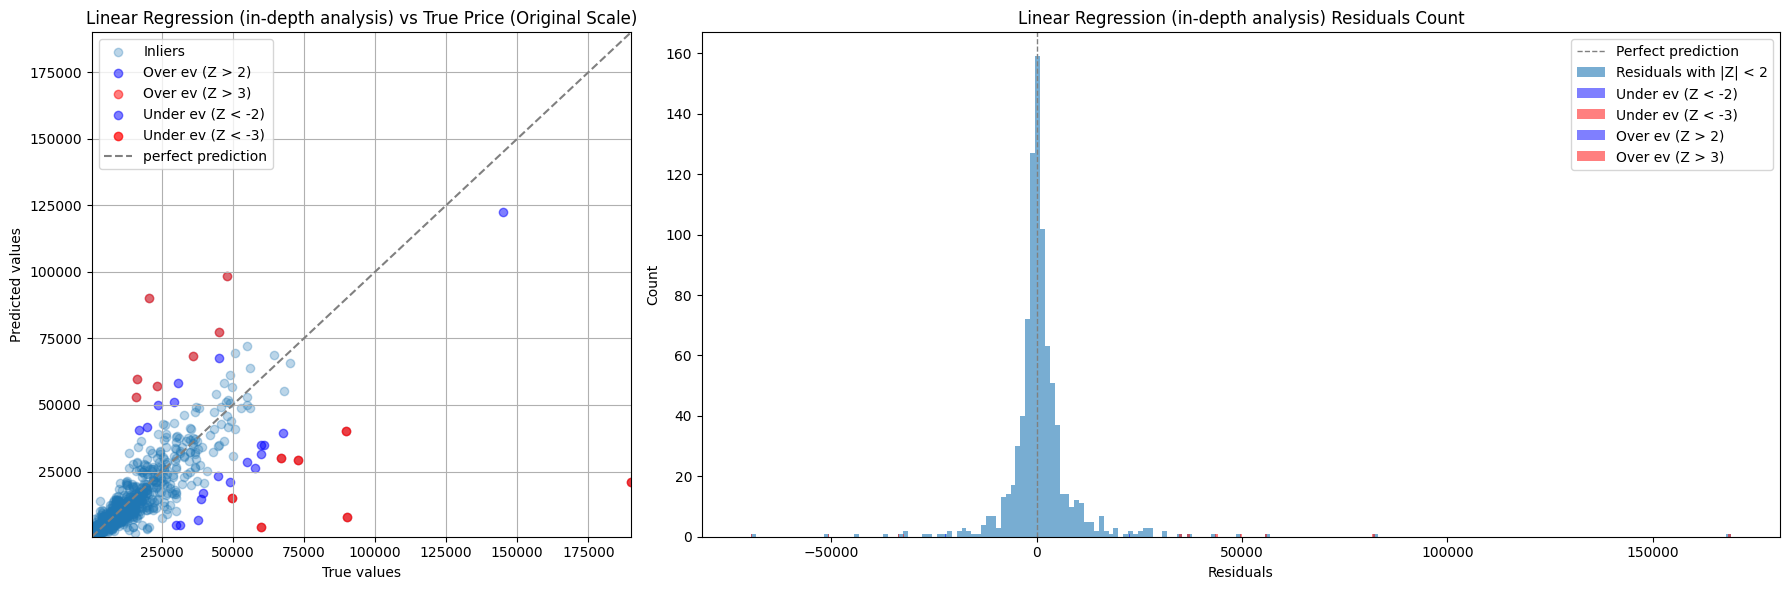

In [ ]:
plt_res.plot_residuals(y_test, y_pred, model_name)

>**Observation**

With no surprise, the same Linear Regression model trained on the entire features space obtain a better performance, although some outliers are still presents.

 We decide to use a K-fold dataset split to research among the entire dataset abnormal entries and continue with an in-dept investigation of these outliers.

### **Thorough Investigation of Outliers**

In [ ]:
pd.set_option('display.max_rows', 100)

preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(),features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

kf = KFold(n_splits=5, shuffle=False)
y_pred_oof = cross_val_predict(pipeline, X, y, cv=kf, method='predict', n_jobs=-1)

z_scores = (10**y_pred_oof - 10**y - np.mean(10**y_pred_oof - 10**y)) / np.std(10**y_pred_oof - 10**y)

model_results = pd.DataFrame({
    "y_true": 10**y,
    "y_pred": 10**y_pred_oof,
    'residuals': 10**y_pred_oof - 10**y,
    'z_scores': z_scores,
    'z_scores_abs' : np.abs(z_scores)
})

outliers_mask = np.abs(z_scores) > 3

df_original = df[['brand', 'model_short', 'year', 'mileage_km' ]].copy()

outliers = df_original.join(model_results[outliers_mask], how='inner')
print(f'Number of outliers on entire dataset: {outliers.shape[0]}')
outliers.sort_values(by='z_scores_abs', ascending=False)

Number of outliers on entire dataset: 41


,brand,model_short,year,mileage_km,y_true,y_pred,residuals,z_scores,z_scores_abs
reference_number,,,,,,,,,
6885736,ROVER,LAND,2019,41000,89800.0,611517.238044,521717.238044,35.932266,35.932266
6064260,MERCEDES-BENZ,A45,2015,97000,29700.0,279884.334504,250184.334504,17.225575,17.225575
8046974,MERCEDES-BENZ,A45,2016,195000,190000.0,21348.802493,-168651.197507,-11.629221,11.629221
8003270,FIAT,124,2020,17700,26900.0,181115.602318,154215.602318,10.614011,10.614011
5369514,FORD,BREAK,2016,50000,8000.0,157039.369999,149039.369999,10.257405,10.257405
8055420,PORSCHE,911,2024,16000,131900.0,265407.667503,133507.667503,9.187381,9.187381
7326795,TOYOTA,SUPRA,2021,10746,50900.0,167731.291866,116831.291866,8.038497,8.038497
7637913,TOYOTA,CHR,2022,42000,20000.0,126628.462977,106628.462977,7.335594,7.335594
5619733,NISSAN,NAVARA,2020,16000,45000.0,140137.903941,95137.903941,6.543976,6.543976


>**Observations**

We investigated the 41 samples which the baseline model would predict as a abnormally higher or lower value (absolute z-score value higher than 3).

Some of these entries appear mistaken from a domain-specific knowledge.
Examples of clearly mistaken entries or typos are:
- listing 7753219, a Skoda Superb of 2011, with a mileage of 170000 km whose price, 90000 CHF, is clearly out of market (could have been probably around 9000).
- listng 8046974, a Mercedes A45, for which a reasonable market price could be around 19K or 20K (predicted price was 21K chf), but whose requested price is 190K. This is an interesting example of mistaken entry, as it leading to errors for also other samples of the same model.

Apart from a few clearly mistaken entries, the other outliers contain true values that seems reasonable from a domain-knowledge point of view.

>**Decision**

As only a few mistaken entries are present and they are marginal. It is worth reducing the impact of those entries by using more complex model and add normalization to improve the model's resistance to outliers.

Additionally, the preliminary EDA highlighted some trends, but non-linear approaches could generalize better with the complex features space, obtained by extracting information from the text features.

We decide to not take any action and keep all the outliers in the dataset.

## **In-Depth Analysis and Data Cleaning Conclusion**

### **Comparing All Linear Regression Baselines Performace**

In [ ]:
results_df = pd.concat([lr_results_df, lr_2_results_df, lr_3_results_df, lr_4_results_df])
results_df.to_csv('/content/drive/MyDrive/_CapstoneProject_/results_df.csv', mode='w')

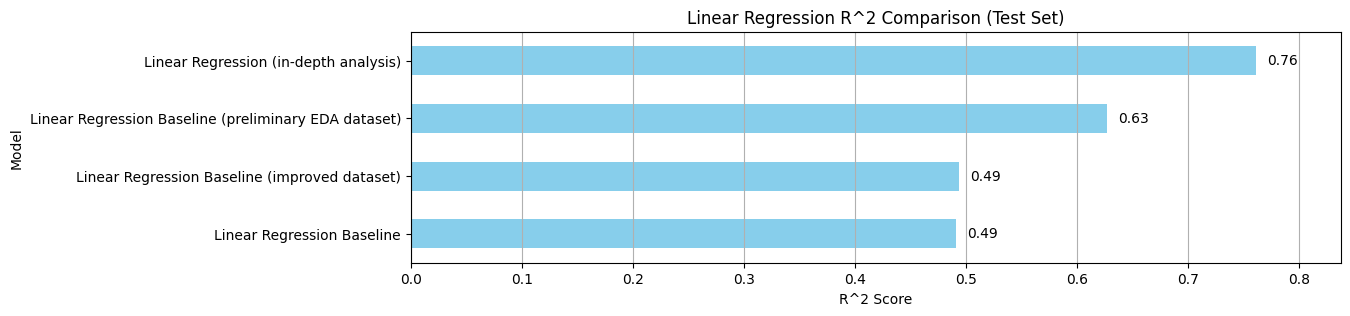

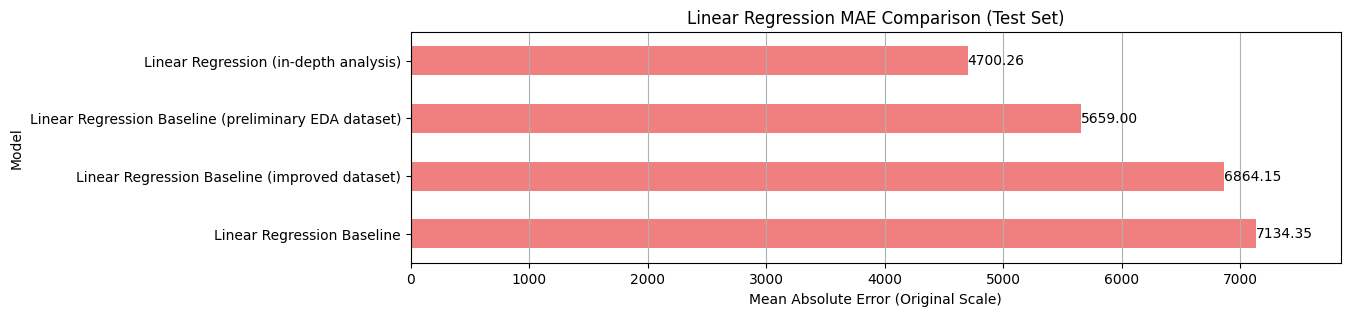

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))

r2_sorted = results_df.sort_values(by='R^2', ascending=True)['R^2']
r2_sorted.plot(kind='barh',  color='skyblue')
ax.set_title('Linear Regression R^2 Comparison (Test Set)')
ax.set_xlabel('R^2 Score')
ax.set_ylabel('Model')
ax.grid(axis='x')

ax.set_xlim(0, r2_sorted.max() * 1.1)
for i, v in enumerate(r2_sorted):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center')


fig, ax = plt.subplots(figsize=(12, 3))

mae_sorted = results_df.sort_values(by='MAE', ascending=False)['MAE']
mae_sorted.plot(kind='barh', color='lightcoral')
ax.set_title('Linear Regression MAE Comparison (Test Set)')
ax.set_xlabel('Mean Absolute Error (Original Scale)')
ax.set_ylabel('Model')
ax.grid(axis='x')

ax.set_xlim(0, mae_sorted.max() * 1.1)

for i, v in enumerate(mae_sorted):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.show()

>**Observation**

The model including the most complete features space obtained from the in-depth analysis acheive a better R^2 score and a lower mean absolute error, demonstrating how the information contained in the text feature play an important role in explaining the variance in the model.

> **Conclusion**

We decide to modify the previous preliminary EDA cleaning preprocess to take into account all the improvement added by the in-depth analysis. This function will be used to preprocess the dataset during the further research for the best regressor.

### **Definitive Data Cleaning Pipeline**

In [ ]:
%%writefile  /content/drive/MyDrive/_CapstoneProject_/data_clean_preprocess.py
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime

# ---- text analysis libraries ----
import unicodedata
import spacy
import string

import nltk
nltk.download('omw-1.4')
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer

def data_clean_preprocess(raw_df, wikipedia_data=True):
  df = raw_df.copy()

  # ----------------- PRELIMINARY OPERATIONS -----------------------------------
  # 1 - Rename Features
  new_columns_names = {
      "Type d'annonce:": 'ad_kind',
      'Numéro de référence:': 'reference_number',
      'Publication:':'date_published',
      'Modèle:': 'model',
      'Année:':'year',
      'Km:':'mileage_km',
      'Prix:': 'price',
      'Transmission:' : 'transmission',
      'Couleur extérieure:' : 'external_color',
      'Couleur intérieure:' : 'internal_color',
      'Carburant:' : 'fuel'
  }
  df.rename(columns=new_columns_names, inplace=True)

  # 2 - Drop Duplicates
  df.drop_duplicates(inplace= True)

  # 3 - Reset Index
  df.set_index('reference_number', inplace=True)

  # 4 - Drop ad_kind feature
  df.drop(columns=['ad_kind'], inplace=True)

  # -----------------  TARGET VARIABLE PREPROCESSING ---------------------------
  # 1 - remove literal characters from the price column
  df.price = df.price.apply(lambda x: str(x).replace("'",'').replace('CHF', '').strip().removesuffix('.-'))

  # check for invalid values in the price column
  invalid_values = df[~df['price'].apply(lambda x: str(x).isdigit())]['price']

  # 2 - remove invalid values
  df = df[df['price'].apply(lambda x: str(x).isdigit())].copy()

  # 3 - cast to integer
  df.price = df.price.astype('int')

  # 4 - remove rows with price lower than 500 CHF
  df = df[df.price >= 500]

  # 5 - remove rows with specific keywords in the description
  df = df[~df.description.str.upper().str.contains('LOCATION')]
  df = df[~df.description.str.upper().str.contains('LOUER')]
  df = df[~df.description.str.upper().str.contains('LOUEZ')]
  df = df[~((df.description.str.upper().str.contains('LEASE')) & (df.price < 2000))]

  # IN-DEPTH analysis add: removing sample presenting keyword LEASING and price less than 2000 CHF
  df =  df[~((df.description.str.upper().str.contains('LEASING')) & (df.price < 2000))]

  # 6 - Applying a logarithmic transformation to the target variable
  df.price = np.log10(df.price)

  # ----------------- NUMERIC FEATURES PREPROCESSING ---------------------------
  ## --------- mileage km ---------
  # 1 - cleaning mileage feature from invalid chars and cast it to integer
  df.mileage_km = df['mileage_km'].apply(lambda x: str(x).replace("'",'').replace('km', '').replace('--','').strip())
  df = df[df['mileage_km'].apply(lambda x: str(x).isdigit())].copy()
  df.mileage_km = df.mileage_km.astype('int')

  # 2 - remove rows with mileage higher than 450000 km
  mileage_threshold = 450000
  df = df[df['mileage_km'] <= mileage_threshold]

  ## --------- year ---------------
  # 1 - Remove vintage cars from the dataset
  df = df[df.year >= datetime.now().year-30]

  # ---------------- DATE AND TIME PREPROCESSING -------------------------------
  # 1 - remove the date_published column from the dataset
  df = df.drop(columns=['date_published'])

  # ---------------- CATEGORICAL FEATURES --------------------------------------
  ## ---------- model -------------------
  # 1 - retreive brand names from the website
  def get_car_brands():
    base_url = "https://www.petitesannonces.ch/"
    headers = {"User-Agent": "Mozilla/5.0"}

    url = base_url + 'r/1403'
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "lxml")
    sous_rubrique_list = soup.find('ul', class_='r')
    car_brands = [a.text.strip() for a in sous_rubrique_list.find_all('a')]

    return car_brands

  car_brands = get_car_brands()

  # 2 - create two more columns: brand and model_short
  brand_list = [b.upper() for b in car_brands]
  def split_brand_model(full_model):
      full_model_upper = full_model.upper()
      for brand in brand_list:
          if full_model_upper.startswith(brand):
              return brand, full_model_upper[len(brand):].strip()
      return "NO_BRAND", full_model_upper.strip()
  df[['brand', 'model_long']] = df['model'].apply(lambda x: pd.Series(split_brand_model(x)))

  # 3 - remove the model column
  df.drop(columns=['model'], inplace=True)

  ## ---------- brand ------------
  # IN-DEPTH analysis add : removing luxury supercars brands
  df = df[~df['brand'].isin(['FERRARI', 'LAMBORGHINI', 'BENTLEY'])]

  # IN-DEPT analysis add: define make grouping by the market segment highlighted by the EDA
  niche_brands_dict = {
    'ASTON MARTIN'  : 'NICHE_LUXURY_BRAND',
    'LOTUS'         : 'NICHE_LUXURY_BRAND',
    'TESLA'         : 'NICHE_LUXURY_BRAND',
    'JAGUAR'        : 'NICHE_LUXURY_BRAND',
    'MASERATI'      : 'NICHE_LUXURY_BRAND',
    'ROVER'         : 'NICHE_LUXURY_BRAND',

    'DODGE'         : 'NICHE_PREMIUM_BRAND',
    'LOTUS'         : 'NICHE_PREMIUM_BRAND',
    'LEXUS'         : 'NICHE_PREMIUM_BRAND',
    'CADILLAC'      : 'NICHE_PREMIUM_BRAND',
    'RELIANT'       : 'NICHE_PREMIUM_BRAND',
    'INFINITI'      : 'NICHE_PREMIUM_BRAND',
    'PONTIAC'       : 'NICHE_PREMIUM_BRAND',

    'AUTRES'        : 'NICHE_MASS_MARKET_BRAND',
    'NO_BRAND'      : 'NICHE_MASS_MARKET_BRAND',
    'DACIA'         : 'NICHE_MASS_MARKET_BRAND',
    'KIA'           : 'NICHE_MASS_MARKET_BRAND',
    'MITSUBISHI'    : 'NICHE_MASS_MARKET_BRAND',
    'SUZUKI'        : 'NICHE_MASS_MARKET_BRAND',
    'SSANG YONG'    : 'NICHE_MASS_MARKET_BRAND',
    'SAAB'          : 'NICHE_MASS_MARKET_BRAND',
    'CHEVROLET'     : 'NICHE_MASS_MARKET_BRAND',
    'MG'            : 'NICHE_MASS_MARKET_BRAND',
    'LANCIA'        : 'NICHE_MASS_MARKET_BRAND',
    'SMART'         : 'NICHE_MASS_MARKET_BRAND',

    'CHRYSLER'      : 'NICHE_ECONOMY_BRAND',
    'DAIHATSU'      : 'NICHE_ECONOMY_BRAND',
    'DAEWOO'        : 'NICHE_ECONOMY_BRAND'
  }
  df['make'] = df['brand'].map(niche_brands_dict).fillna(df['brand'])

  ## ---------- model short --------------
  # 1 - clean the model_short feature by keeping only the first word
  df['model_short'] = df['model_long'].str.split().str[0]

  ## --------- transmission -------------
  ### no preprocessing, will need integer encoding

  ## --------- fuel --------------------
  # 1 - replace 'Gaz naturel' with 'Gaz naturel/Essence' in the fuel column
  df['fuel'] = df['fuel'].replace({
      'Gaz naturel': 'Gaz naturel/Essence'
  })
  ### will need integer encoding

  # ----------- external color -----------------
  # 1 - create a external color short feature
  df['external_color_short'] = df.external_color.apply(lambda x: x.split(' ')[0])

  # 2 - create an external_color_grouped feature
  df['external_color_grouped'] = df['external_color_short'].apply(lambda x : x if x in ['Noir', 'Gris', 'Blanc', 'Anthracite', 'Bleu'] else 'Autres')

  # 3 - create external color shade feature
  df['external_color_shade'] =  np.where(
    df['external_color'].str.contains('foncé|clair', na=False),
    df['external_color'].str.split(' ').str[1],
    'normal'
  )

  # 4 - create external color metallic finish feature
  df['external_color_metallic'] =  np.where(
    df['external_color'].str.contains(r'\(métallisé\)', na=False),
    df['external_color'].str.split(' ').str[-1],
    'normal'
  )

  # ------------- internal color ------------------
  # 1 - split into internal_color_short feature
  df['internal_color_short'] = df.internal_color.apply(lambda x: x.split(' ')[0])

  # 2 - create an internal_color_grouped feature
  df['internal_color_grouped'] = df['internal_color_short'].apply(lambda x : x if x in ['Noir', 'Gris',  'Anthracite'] else 'Autres')

  # 3 - create internal color shade feature
  df['internal_color_shade'] =  np.where(
    df['internal_color'].str.contains('foncé|clair', na=False),
    df['internal_color'].str.split(' ').str[1],
    'normal'
  )

  # 4 - create internal color leather material feature
  df['internal_color_leather'] =  np.where(
    df['internal_color'].str.contains('cuir', na=False),
    df['internal_color'].str.split(' ').str[-1],
    'normal'
  )

  # --------------- description feature preprocessing -----------------
  # 1 - convert to lowercase
  df['description'] = df.description.str.lower()

  # 2 - normalize accents
  def strip_accents(text):
      return ''.join(
          c for c in unicodedata.normalize('NFD', text)
          if unicodedata.category(c) != 'Mn'
      )

  df['description'] = df['description'].apply(strip_accents)

  # 3 - tokenization
  tokenizer = TreebankWordTokenizer()
  def review_tokinzer(text):
    words = []
    words.extend(tokenizer.tokenize(text))
    return words

  df['description'] = df.description.apply(lambda x: review_tokinzer(x))

  # 4 - stopwords removal
  stopwords_french = stopwords.words("french")
  not_stopwords = ['pas', 'sans', 'n', 'ne', 'ni']
  custom_stopwords = set(
      [word for word in stopwords_french if word not in not_stopwords]
  )

  df.description = df.description.apply(
      lambda x: [word for word in x if word not in custom_stopwords]
  )

  # 5 - ponctuation removal
  df['description'] = df.description.apply(lambda x: [word for word in x if word not in string.punctuation])

  # 6 - stemming
  stemmer = PorterStemmer()
  df['description'] = df.description.apply(lambda x: [stemmer.stem(word) for word in x])
  df['description'] = df.description.apply(lambda x: " ".join(x))

  # ---------------- description features extraction ----------------------
  ## ------------- feature length
  # 1 - create descripton length feature
  df['description_length'] = df.description.apply(lambda x: len(x.split()))

  ## ------------- extract unigrams and bigrams ---------------
  # 1 - extract unigrams "flags"
  count_unigrams_vec = CountVectorizer(
      ngram_range=(1,1),
      min_df=5,
      binary = True
  )
  descriptions_unigrams_count = count_unigrams_vec.fit_transform(df.description)

  unigram_counts = descriptions_unigrams_count.sum(axis=0).A1
  unigrams = count_unigrams_vec.get_feature_names_out()

  # 2 - extract bigrams "flags"
  count_bigram_vec = CountVectorizer(
      ngram_range=(2,2),
      min_df=5,
      binary = True
  )
  descriptions_bigrams_count = count_bigram_vec.fit_transform(df.description)

  bigrams_counts = descriptions_bigrams_count.sum(axis=0).A1
  bigrams = count_bigram_vec.get_feature_names_out()

  # 3 - transform the two sparses matrices into datasets
  df_unigrams = pd.DataFrame(
      descriptions_unigrams_count.toarray(),
      index=df.index,
      columns=unigrams
  )

  df_bigrams = pd.DataFrame(
      descriptions_bigrams_count.toarray(),
      index=df.index,
      columns=bigrams
  )

  # 4 - join unigrams and bigrams
  df_description_features = df_unigrams.join(
      df_bigrams,
      how='inner'
  )

  ## ----------- create the conditions flags -----------------------
  # 1 - create a very_bad_condition flag
  uni_bi_grams = [
      'abim',
      'abime',
      'export',
      'impact',
      'san garanti',
      'san garantie',
      'aucun garanti'
  ]

  existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

  if existing_cols:
      df_description_features['very_bad_condition'] = df_description_features[existing_cols].max(axis=1)
  else:
      df_description_features['very_bad_condition'] = 0

  # 2 - create a minor_wear_condition flag
  uni_bi_grams = [
    'defaut'
    ,'defectueux'
    ,'griff'
    ,'griffur'
    ,'marqu'
    ,'trace'
    ,'rayur'
    ,'bruit'
    ,'usur'
    ,'rouill'
    ,'petit travaux'
    ,'travaux prevoir'
  ]

  existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

  if existing_cols:
      df_description_features['minor_wear_condition'] = df_description_features[existing_cols].max(axis=1)
  else:
      df_description_features['minor_wear_condition'] = 0

  # 3 - create a good_condition flag
  uni_bi_grams = [
      'jamai accident'
    , 'jamai accidente'
    , 'non accident'
    , 'non accidente'
    , 'non accidentee'
    , 'quasi neuf'
    , 'quasi neufs'
    , 'quasiment neuf'
    , 'travaux effectu'
    , 'aucun problem'
    , 'aucun souci'
    , 'aucun defaut'
    , 'pa problem'
    , 'san problem'
    , 'san souci'
    , 'bon'
    , 'bonn'
    , 'affair'
    , 'correct'
    , 'entretenu'
    , 'entretenue'
    , 'confortable'
    , 'fiabilit'
    , 'fiabilite'
    , 'fiabl'
    , 'fiable'
    , 'fonctionnel'
    , 'fraichement'
    , 'normal'
    , 'soign'
    , 'soigne'
    , 'soignee'
    , 'soigner'
    , 'soigneus'
    , 'soin'
    , 'reguli'
    , 'regulier'
    , 'regulierement'
  ]

  existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

  if existing_cols:
      df_description_features['good_condition'] = df_description_features[existing_cols].max(axis=1)
  else:
      df_description_features['good_condition'] = 0

  # 4 - create a excellent_condition flag
  uni_bi_grams = [
        'bijou'
      , 'excel'
      , 'excellent'
      , 'except'
      , 'exceptionnel'
      , 'exclusif'
      , 'exclusiv'
      , 'super'
      , 'superb'
      , 'elegant'
      , 'impec'
      , 'impecc'
      , 'impeccable'
      , 'intemporel'
      , 'irreproch'
      , 'irreprochable'
      , 'magnifiqu'
      , 'meilleur'
      , 'neuf'
      , 'neufs'
      , 'neuv'
      , 'neuve'
      , 'neuves'
      , 'nouveau'
      , 'nouveaux'
      , 'nouvel'
      , 'parfait'
      , 'parfaitement'
      , 'rigoureux'
      , 'special'
      , 'speciaux'
  ]

  existing_cols = [c for c in uni_bi_grams if c in df_description_features.columns]

  if existing_cols:
      df_description_features['excellent_condition'] = df_description_features[existing_cols].max(axis=1)
  else:
      df_description_features['excellent_condition'] = 0

  ## ------------------------------- extract technical characteristics --------------------
  # 1 -  unigram features selection
  tec_char_unigrams_to_retain = ['economiqu', 'airbag', 'xenon', 'led', 'crochet']
  for f in tec_char_unigrams_to_retain:
      if f not in df_unigrams.columns:
          df_unigrams[f] = 0

  df_unigrams = df_unigrams[tec_char_unigrams_to_retain]

  # 2 - create groups of synonyms
  expenses_features_to_group = ['aucun frai', 'pa frai']
  winter_tire_features_to_group = ['pneu hiver', 'pneu neig', 'roue hiver', 'roue neig', 'jant hiver', 'jant neig']
  summer_tire_features_to_group = ['pneu ete',  'roue ete',  'jant ete']
  tires_ok_features_to_group = ['pneu bon', 'pneu neuf', 'jeux pneu', 'jeu pneu', 'pneu quasi', 'roue bon', 'roue bonn', 'roue neuv', 'roue quasi', 'jeu roue']
  full_option_to_group = ['tout option', 'full option', 'nombreus option', 'beaucoup option']
  rearview_camera_to_group = ['camera recul', 'rearview camera']
  recent_inspection_to_group = ['expertise jour', 'expertis jour']
  recent_service_to_group = ['service jour', 'service fait', 'servic effectue', 'servic suivi', 'tou servic', 'carnet servic', 'grand servic', 'carnet entretien']
  non_smoking_to_group = ['non fumeur', 'non fumeus']
  first_hand_to_group = ['premier main', '1ere main']
  sound_system_to_group = ['haut parleur', 'system audio']
  sunroof_to_group = ['toit ouvrant', 'toit panoramiqu']

  # 3 - select only existing ones
  expenses_features_existing = [f for f in expenses_features_to_group if f in df_bigrams.columns]
  winter_tire_features_existing = [f for f in winter_tire_features_to_group if f in df_bigrams.columns]
  summer_tire_features_existing = [f for f in summer_tire_features_to_group if f in df_bigrams.columns]
  tires_ok_features_existing = [f for f in tires_ok_features_to_group if f in df_bigrams.columns]
  full_option_existing = [f for f in full_option_to_group if f in df_bigrams.columns]
  rearview_camera_existing = [f for f in rearview_camera_to_group if f in df_bigrams.columns]
  recent_inspection_existing = [f for f in recent_inspection_to_group if f in df_bigrams.columns]
  recent_service_existing = [f for f in recent_service_to_group if f in df_bigrams.columns]
  non_smoking_existing = [f for f in non_smoking_to_group if f in df_bigrams.columns]
  first_hand_existing = [f for f in first_hand_to_group if f in df_bigrams.columns]
  sound_system_existing = [f for f in sound_system_to_group if f in df_bigrams.columns]
  sunroof_existing = [f for f in sunroof_to_group if f in df_bigrams.columns]


  # 4 - group per semanting meaning in a single one-hot encoded feature
  df_bigrams["expenses"] =  df_bigrams[expenses_features_existing].any(axis=1).astype(int) if len(expenses_features_existing) > 0 else 0
  df_bigrams["winter_tire"] =  df_bigrams[winter_tire_features_existing].any(axis=1).astype(int) if len(winter_tire_features_existing) > 0 else 0
  df_bigrams["summer_tire"] =  df_bigrams[summer_tire_features_existing].any(axis=1).astype(int) if len(summer_tire_features_existing) > 0 else 0
  df_bigrams["tires_ok"] =  df_bigrams[tires_ok_features_existing].any(axis=1).astype(int) if len(tires_ok_features_existing) > 0 else 0
  df_bigrams["full_option"] =  df_bigrams[full_option_existing].any(axis=1).astype(int) if len(full_option_existing) > 0 else 0
  df_bigrams["rearview_camera"] =  df_bigrams[rearview_camera_existing].any(axis=1).astype(int) if len(rearview_camera_existing) > 0 else 0
  df_bigrams["recent_inspection"] =  df_bigrams[recent_inspection_existing].any(axis=1).astype(int) if len(recent_inspection_existing) > 0 else 0
  df_bigrams["recent_service"] =  df_bigrams[recent_service_existing].any(axis=1).astype(int) if len(recent_service_existing) > 0 else 0
  df_bigrams["non_smoking"] =  df_bigrams[non_smoking_existing].any(axis=1).astype(int) if len(non_smoking_existing) > 0 else 0
  df_bigrams["first_hand"] =  df_bigrams[first_hand_existing].any(axis=1).astype(int) if len(first_hand_existing) > 0 else 0
  df_bigrams["sound_system"] =  df_bigrams[sound_system_existing].any(axis=1).astype(int) if len(sound_system_existing) > 0 else 0
  df_bigrams["sunroof"] =  df_bigrams[sunroof_existing].any(axis=1).astype(int) if len(sunroof_existing) > 0 else 0

  # 5 - determine a list of bigrams with no synonym (no grouping required)
  bigrams_with_no_synonims = [
      'sieg chauffant',
      'regulateur vitess',
      'prix discut',
      'vitr electriqu',
      'climatis automatiqu',
      'system navig',
      'direct assiste',
      'courroi distribut',
      'verrouillag central',
      'barr toit',
      'disqu plaquett',
      'main libr',
      'airbag lateraux',
      'roue motric',
      'accoudoir central',
      'detecteur pluie',
      'phare antibrouillard',
      'volant multifonct',
      'volant cuir',
      'assist freinag',
      'start stop'
  ]

  for f in bigrams_with_no_synonims:
      if f not in df_bigrams.columns:
          df_bigrams[f] = 0

  # 6 - keep only selected bigrams and standardize features names
  tec_char_bigrams_to_retain = ['expenses', 'winter_tire', 'summer_tire', 'tires_ok', 'full_option', 'rearview_camera', 'recent_inspection', 'recent_service', 'non_smoking', 'first_hand', 'sound_system', 'sunroof'] + bigrams_with_no_synonims
  df_bigrams = df_bigrams[tec_char_bigrams_to_retain]
  df_bigrams.columns = df_bigrams.columns.str.replace(" ", "_")

  # 7 - join with conditions features
  conditions_features = ['very_bad_condition', 'minor_wear_condition', 'good_condition', 'excellent_condition']
  df_description_features = df_description_features[conditions_features].join(df_unigrams.join(df_bigrams),how='inner')

  # 8 ---- finalise description features selection
  description_features_to_retain = [
    'very_bad_condition',
    'minor_wear_condition',
    'good_condition',
    'excellent_condition',
    'economiqu',
    'airbag',
    'xenon',
    'led',
    'crochet',
    'expenses',
    'winter_tire',
    'summer_tire',
    'tires_ok',
    'full_option',
    'rearview_camera',
    'recent_inspection',
    'recent_service',
    'non_smoking',
    'first_hand',
    'sound_system',
    'sunroof',
    'sieg_chauffant',
    'regulateur_vitess',
    'prix_discut',
    'vitr_electriqu',
    'climatis_automatiqu',
    'system_navig',
    'direct_assiste',
    'courroi_distribut',
    'verrouillag_central',
    'detecteur_pluie',
    'phare_antibrouillard',
    'volant_multifonct'
  ]
  df_description_features = df_description_features[description_features_to_retain]

  ## -------------- extract model features --------------
  # 1 - extract CABRIO and TURBO keywords
  df['cabrio'] = df['model_long'].str.contains('CABRIO').astype(int)
  df['turbo'] = df['model_long'].str.contains('TURBO').astype(int)

  # 2 - extract engine size from model_long
  engine_size_pattern = r'(\b[0-9]\.[0-9]\b)'
  df['engine_size'] = df['model_long'].str.extract(engine_size_pattern)
  df['engine_size'] = df['engine_size'].astype(float)
  df.fillna({'engine_size' : df.engine_size.median()}, inplace=True)

  # 3 - extract horsepower
  horsepower_pattern = r'(\b[0-9]{1,3}CV)\b'
  df['horsepower'] = df['model_long'].str.extract(horsepower_pattern)
  df['horsepower'] = df['horsepower'].str.replace('CV', '')
  df['horsepower'] = df['horsepower'].astype(float)
  df.fillna({'horsepower' : df.horsepower.median()}, inplace=True)

  # extract valves
  valves_pattern = r'(\b[0-9]{1,2}V)\b'
  df['valves'] = df['model_long'].str.extract(valves_pattern)
  df['valves'] = df['valves'].str.replace('V', '')
  df['valves'] = df['valves'].astype(float)
  df.fillna({'valves' : 4}, inplace=True)

  # extract v engine
  v_engine_pattern = r'(\bV[0-9])\b'
  df['v_engine'] = df['model_long'].str.extract(v_engine_pattern)
  df['v_engine'] = df['v_engine'].str.replace('V', '')
  df['v_engine'] = df['v_engine'].astype(float)
  df.fillna({'v_engine' : 0}, inplace=True)

  # extract model short
  df['model_short'] = df['model_long'].str.split().str[0]

  ## -------------------- FINAL FEATURES SELECTION ----------------------------
  # 1 - join original dataset with the extracted description features dataset
  df = df.join(df_description_features, how='inner')

  # 2 - group retained features by kind
  features_dict = {
  'numerical_features' : [
      'year',
      'mileage_km',
      'engine_size',
      'horsepower',
      'valves',
      'v_engine',
      'description_length'
  ],
  'categorical_features' : [
      'transmission',
      'fuel',
      'make',
      'model_short',
      'external_color_grouped',
      'external_color_shade',
      'external_color_metallic',
      'internal_color_grouped',
      'internal_color_shade',
      'internal_color_leather'
  ],
  'binary_features' : [
      'very_bad_condition',
      'minor_wear_condition',
      'good_condition',
      'excellent_condition',
      'cabrio',
      'turbo',
      'economiqu',
      'airbag',
      'xenon',
      'led',
      'crochet',
      'expenses',
      'winter_tire',
      'summer_tire',
      'tires_ok',
      'full_option',
      'rearview_camera',
      'recent_inspection',
      'recent_service',
      'non_smoking',
      'first_hand',
      'sound_system',
      'sunroof',
      'sieg_chauffant',
      'regulateur_vitess',
      'prix_discut',
      'vitr_electriqu',
      'climatis_automatiqu',
      'system_navig',
      'direct_assiste',
      'courroi_distribut',
      'verrouillag_central',
      'detecteur_pluie',
      'phare_antibrouillard',
      'volant_multifonct'
  ],
      'target_variable': ['price']
  }

  # 3 - drop original columns that have been analysed and splitted in multiple features (e.g. description and model)
  retained_feat = [item for sublist in features_dict.values() for item in sublist]
  df = df[retained_feat]

  return features_dict, df

Overwriting /content/drive/MyDrive/_CapstoneProject_/data_clean_preprocess.py
